<a href="https://colab.research.google.com/github/gayecolakoglu/DiabeticRetinopathyDetection/blob/main/Bayesian_DenseNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pathlib
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
#https://medium.com/@pierre.beaujuge/bayesian-optimization-on-the-head-classifier-of-pre-trained-cnns-using-the-cifar10-dataset-48c440b67b2c
# Install GPy, GPyOpt
!pip install tensorflow-addons
!pip install GPy==1.9.8
!pip install GPyOpt==1.2.1
import tensorflow as tf
import tensorflow.keras as K
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
import GPy
import GPyOpt
import tensorflow as tf
import tensorflow_addons as tfa
from GPyOpt.methods import BayesianOptimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install split-folders
import splitfolders
splitfolders.ratio('/content/gdrive/MyDrive/KaggleImageData/allDataCLAHE', output="output", seed=1337, ratio=(.7, 0.2, 0.1)) #train,val,test

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 11586 files [01:00, 192.09 files/s]


In [3]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
!pip install image-dataset-loader
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'val'])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
def preprocess_data(X, Y):
    """
    function that pre-processes the DR dataset as per
    densenet model requirements for input images
    labels are one-hot encoded
    """
    X = K.applications.densenet.preprocess_input(X)
    Y = K.utils.to_categorical(Y)
    return X, Y

In [5]:
# preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_train, y_train = preprocess_data(x_train, y_train)
x_test, y_test = preprocess_data(x_test, y_test)

In [6]:
input_tensor = K.Input(shape=(32, 32, 3))
# resize images to the image size upon which the network was pre-trained
resized_images = K.layers.Lambda(lambda image: tf.image.resize(image, (224, 224)))(input_tensor)
base_model = K.applications.DenseNet201(include_top=False,
                                        weights='imagenet',
                                        input_tensor=resized_images,
                                        input_shape=(224, 224, 3),
                                        pooling='max',
                                        classes=5)
output = base_model.layers[-1].output
base_model = K.models.Model(inputs=input_tensor, outputs=output)

In [ ]:
# using the training data
train_datagen = K.preprocessing.image.ImageDataGenerator()# no data augmentation for train set we did that in seperate code for class 1,3 and 4
      
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size=32,
                                     shuffle=False)
features_train = base_model.predict(train_generator)

In [7]:
# repeat the same operation with the test data (here used for validation)
val_datagen = K.preprocessing.image.ImageDataGenerator()  # no augmentation for validation set
val_generator = val_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_valid = base_model.predict(val_generator)

In [11]:
'''
from keras import backend

def recall_m(y_true, y_pred):
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    possible_positives = backend.sum(backend.round(backend.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + backend.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)))
    predicted_positives = backend.sum(backend.round(backend.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + backend.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+backend.epsilon()))
'''

In [22]:
def build_model(units=256, learning_rate=1e-4, l2=1e-2, activation=2, rate=0.5, batch=32, optim=1):
  """function that builds a model for the head classifier"""
  # weights are initialized as per the he et al. method
  initializer = K.initializers.he_normal()
  input_tensor = K.Input(shape=features_train.shape[1])
  activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
  optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
  layer = K.layers.Dense(units=units,
                         activation=activation_dict[activation],
                         kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = layer(input_tensor)
  dropout = K.layers.Dropout(rate)
  output = dropout(output)
  softmax = K.layers.Dense(units=5,
                           activation='softmax',
                           kernel_initializer=initializer,
                        kernel_regularizer=K.regularizers.l2(l2=l2))
  output = softmax(output)
  model = K.models.Model(inputs=input_tensor, outputs=output)
  # compile the densely-connected head classifier (here, "model")
  if optim==1:
    model.compile(
            optimizer=K.optimizers.Adam(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  elif optim==2:
    model.compile(
            optimizer=K.optimizers.SGD(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  elif optim==3:
    model.compile(
            optimizer=K.optimizers.RMSprop(learning_rate=learning_rate),
            loss='categorical_crossentropy',
            metrics=["accuracy"])
  else:
    print("Wrong optimizer!!")
  # Define some callback functions to be used by the model during training
  # reduce learning rate when val_accuracy has stopped improving
  lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                            factor=0.6,
                                            patience=2,
                                            verbose=1,
                                            mode='max',
                                            min_lr=1e-7)
  # stop training when val_accuracy has stopped improving
  early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                         patience=3,
                                         verbose=1,
                                         mode='max')
  # callback to save the Keras model and (best) weights obtained on an epoch basis
  checkpoint = K.callbacks.ModelCheckpoint('DR.h5',
                                           monitor='val_accuracy',
                                           verbose=1,
                                           save_weights_only=False,
                                           save_best_only=True,
                                           mode='max',
                                           save_freq='epoch')
  return model, lr_reduce, early_stop, checkpoint, batch

In [13]:
def fit_model(model, lr_reduce, early_stop, checkpoint, batch):
  """function that trains the head classifier"""
  history = model.fit(features_train, y_train,
                      batch_size=batch,
                      epochs=100,
                      verbose=0,
                      callbacks=[lr_reduce, early_stop, checkpoint],
                      validation_data=(features_valid, y_test),
                      shuffle=True)
  return history

In [14]:
def evaluate_model(model):
  """function that evaluates the head classifier"""
  evaluation = model.evaluate(features_valid, y_test)
  return evaluation


Hyperparameters: [[6.40e+01 1.00e-05 1.00e-02 1.00e+00 5.00e-01 2.56e+02 1.00e+00]]

Epoch 1: val_accuracy improved from -inf to 0.14039, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.14039

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.14039

Epoch 4: val_accuracy improved from 0.14039 to 0.18488, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.18488 to 0.30367, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.30367 to 0.38143, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.38143 to 0.43283, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.43283 to 0.45961, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.45961 to 0.47041, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.47041

Epoch 11: val_accuracy improved from 0.47041 to 0.47214, saving model to DR.h5

Epoch 12: val_accuracy did not improve from 0.4721

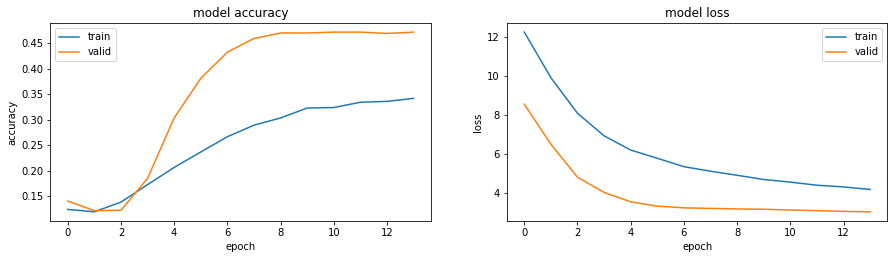


Hyperparameters: [[6.40e+01 1.00e-06 1.00e-02 2.00e+00 7.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 2ms/step - loss: 3.0425 - accuracy: 0.4721

Epoch 1: val_accuracy improved from -inf to 0.18186, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.18186 to 0.23801, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.23801 to 0.28942, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.28942 to 0.33780, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.33780 to 0.38013, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.38013 to 0.42117, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.42117 to 0.45572, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.45572 to 0.46739, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.46739 to 0.47948, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.47948 to 0.49114, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

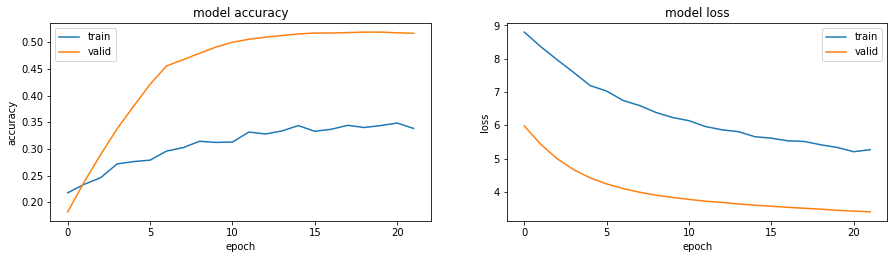


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 2.00e+00 5.00e-01 3.20e+01 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 3.4032 - accuracy: 0.5171

Epoch 1: val_accuracy improved from -inf to 0.61641, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.61641

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.61641

Epoch 4: val_accuracy did not improve from 0.61641
Epoch 4: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.1874 - accuracy: 0.6138

LOSS:	1.1873583793640137 	 ACCURACY:	0.613822877407074
[1.1873583793640137, 0.613822877407074]



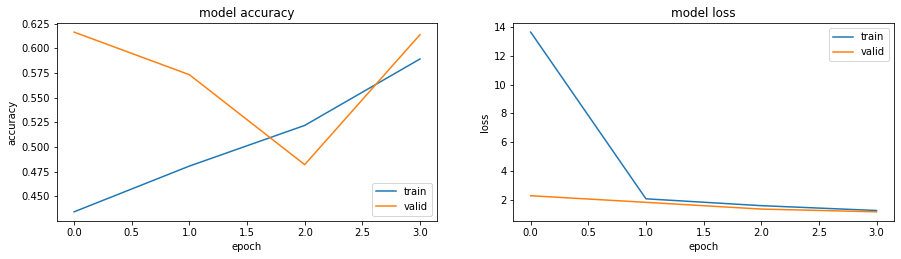


Hyperparameters: [[1.28e+02 1.00e-05 1.00e-02 3.00e+00 3.00e-01 2.56e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.1874 - accuracy: 0.6138

Epoch 1: val_accuracy improved from -inf to 0.33909, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.33909 to 0.36415, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.36415 to 0.38790, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.38790 to 0.40130, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.40130 to 0.42073, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.42073 to 0.42894, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.42894 to 0.43844, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.43844 to 0.44492, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.44492 to 0.45313, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.45313 to 0.45832, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

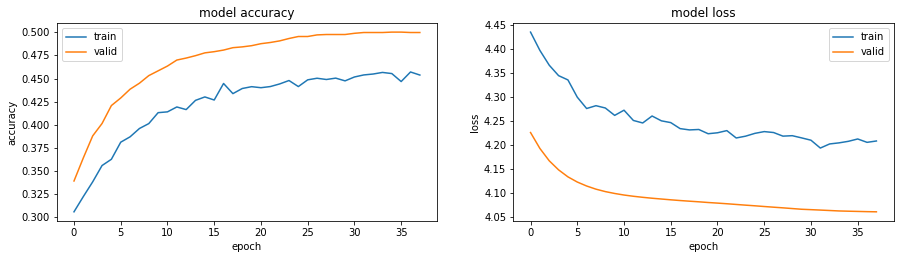


Hyperparameters: [[2.56e+02 1.00e-06 1.00e-02 1.00e+00 7.00e-01 3.20e+01 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1874 - accuracy: 0.6138

Epoch 1: val_accuracy improved from -inf to 0.14816, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.14816 to 0.17365, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.17365 to 0.21728, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.21728 to 0.29546, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.29546 to 0.36285, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.36285 to 0.42073, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.42073 to 0.46393, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.46393 to 0.48985, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.48985 to 0.50540, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.50540 to 0.51879, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

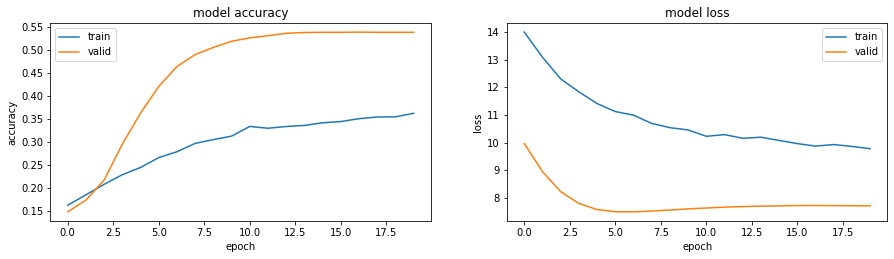




Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 3.00e+00 5.00e-01 2.56e+02 3.00e+00]]
73/73 [==============================] - 1s 4ms/step - loss: 1.1874 - accuracy: 0.6138

Epoch 1: val_accuracy improved from -inf to 0.54514, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54514 to 0.60994, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.60994 to 0.62419, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.62419

Epoch 5: val_accuracy improved from 0.62419 to 0.63240, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.63240 to 0.63629, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.63629

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 8: val_accuracy did not improve from 0.63629

Epoch 9: val_accuracy did not improve from 0.63629
Epoch 9: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.0524 - accuracy: 0.6359

LOSS:	1.0524091720581055 	 ACCURACY:	

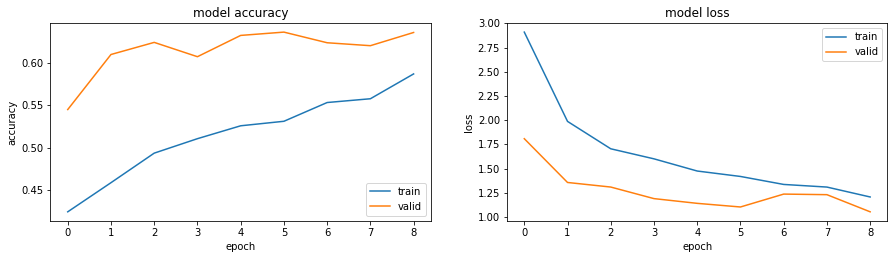


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 2.00e+00 3.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0524 - accuracy: 0.6359

Epoch 1: val_accuracy improved from -inf to 0.41771, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.41771 to 0.46263, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.46263 to 0.47646, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.47646 to 0.48467, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.48467 to 0.49071, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.49071 to 0.49158, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.49158

Epoch 8: val_accuracy improved from 0.49158 to 0.49892, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.49892 to 0.49978, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.49978 to 0.50626, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.50626

Epoch 12: val

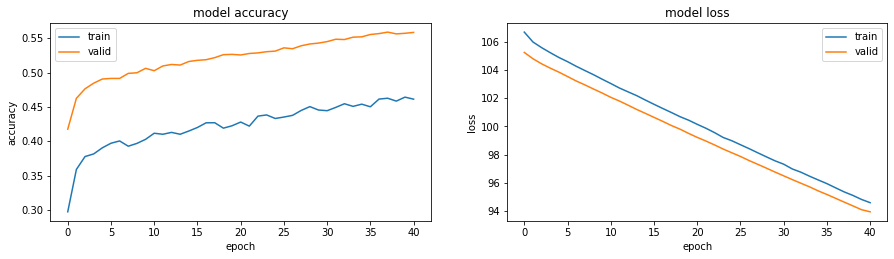


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 3.00e+00 3.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0524 - accuracy: 0.6359

Epoch 1: val_accuracy improved from -inf to 0.53261, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.53261 to 0.57711, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.57711 to 0.60302, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.60302 to 0.60734, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.60734 to 0.61771, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.61771 to 0.62160, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.62160 to 0.62592, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.62592

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 9: val_accuracy did not improve from 0.62592

Epoch 10: val_accuracy improved from 0.62592 to 0.62894, saving model to DR.h5

Epoch 11: val_ac

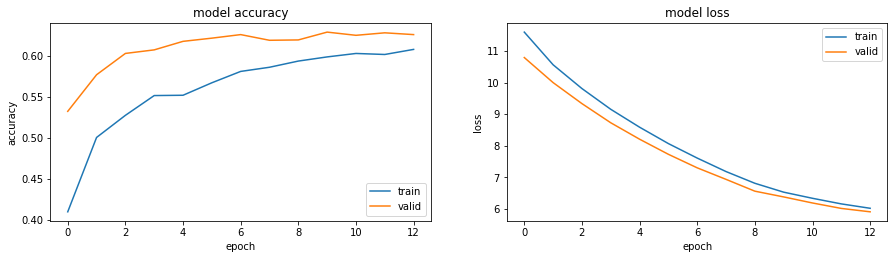


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 1.00e+00 3.00e-01 3.20e+01 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.0524 - accuracy: 0.6359

Epoch 1: val_accuracy improved from -inf to 0.47214, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.47214 to 0.47905, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.47905 to 0.49201, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.49201 to 0.49503, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.49503 to 0.49892, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.49892 to 0.50713, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.50713

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 8: val_accuracy did not improve from 0.50713

Epoch 9: val_accuracy improved from 0.50713 to 0.51102, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.51102 to 0.51317, saving model to DR.h5

Epoch 11: val_ac

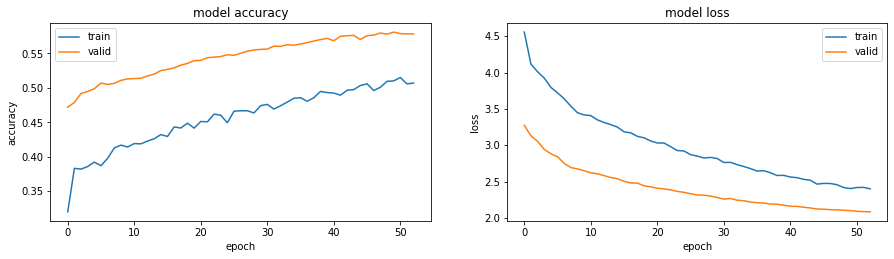


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 3.00e+00 7.00e-01 2.56e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0524 - accuracy: 0.6359

Epoch 1: val_accuracy improved from -inf to 0.54298, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54298 to 0.54341, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.54341

Epoch 4: val_accuracy improved from 0.54341 to 0.54471, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.54471 to 0.54687, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.54687 to 0.55032, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.55032 to 0.55378, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.55378 to 0.55853, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.55853 to 0.56587, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.56587 to 0.57019, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.57019 to 0.57624, saving mo

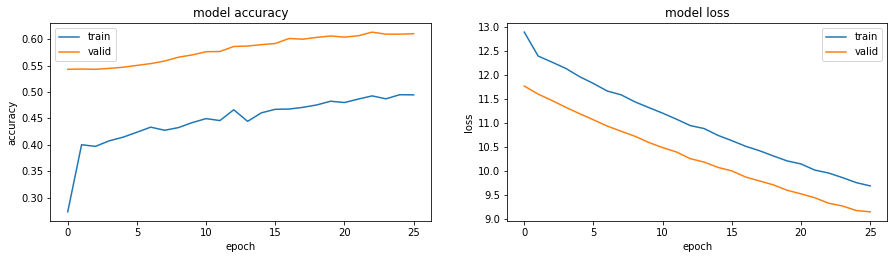


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 3.00e+00 5.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0524 - accuracy: 0.6359

Epoch 1: val_accuracy improved from -inf to 0.52441, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.52441 to 0.53132, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.53132 to 0.53477, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.53477 to 0.53650, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.53650

Epoch 6: val_accuracy improved from 0.53650 to 0.53996, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.53996 to 0.54168, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.54168 to 0.54600, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.54600 to 0.54860, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.54860 to 0.55378, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.55378 to 0.55464, saving mo

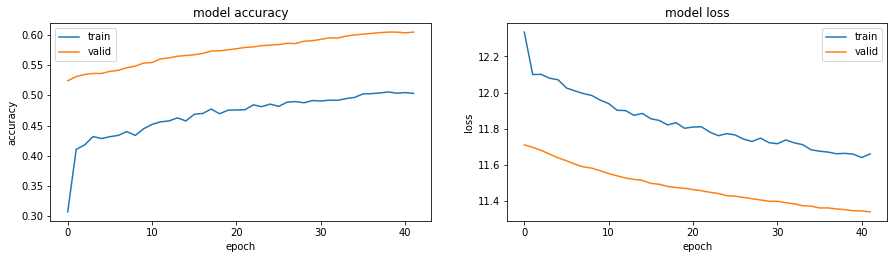


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 1.00e+00 7.00e-01 2.56e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0524 - accuracy: 0.6359

Epoch 1: val_accuracy improved from -inf to 0.24147, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.24147 to 0.33564, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.33564 to 0.42030, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.42030 to 0.47430, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.47430 to 0.50497, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.50497 to 0.51922, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.51922 to 0.52700, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.52700 to 0.53305, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.53305

Epoch 10: val_accuracy improved from 0.53305 to 0.53477, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.53477 to 0.53737, saving mo

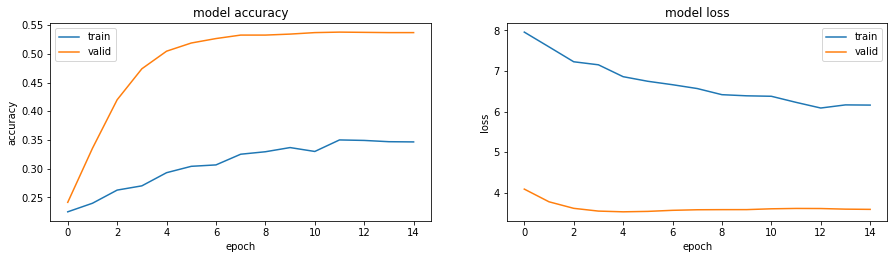


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 1.00e+00 3.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.0524 - accuracy: 0.6359

Epoch 1: val_accuracy improved from -inf to 0.57408, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.57408 to 0.62376, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.62376 to 0.62505, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.62505 to 0.64060, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.64060

Epoch 6: val_accuracy improved from 0.64060 to 0.64536, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.64536

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 8: val_accuracy did not improve from 0.64536

Epoch 9: val_accuracy did not improve from 0.64536
Epoch 9: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.3202 - accuracy: 0.6406

LOSS:	1.320167064666748 	 ACCURACY:	0.6

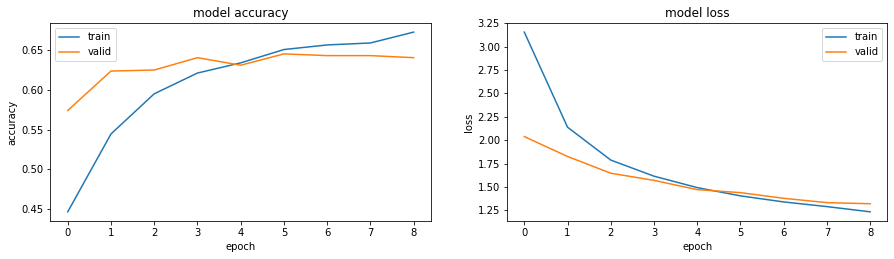


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 3.00e+00 3.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.3202 - accuracy: 0.6406

Epoch 1: val_accuracy improved from -inf to 0.62333, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.62333

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.62333

Epoch 4: val_accuracy improved from 0.62333 to 0.63542, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.63542 to 0.64536, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.64536

Epoch 7: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 7: val_accuracy did not improve from 0.64536

Epoch 8: val_accuracy did not improve from 0.64536
Epoch 8: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 2.7295 - accuracy: 0.6410

LOSS:	2.7295145988464355 	 ACCURACY:	0.6410366892814636
[2.729514598

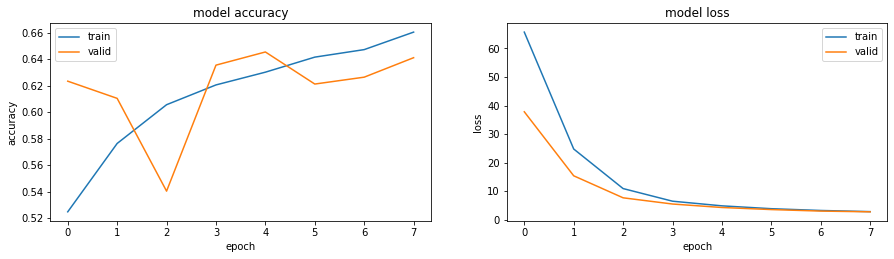


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 2.00e+00 7.00e-01 3.20e+01 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 2.7295 - accuracy: 0.6410

Epoch 1: val_accuracy improved from -inf to 0.60216, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.60216 to 0.61857, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61857 to 0.63067, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.63067 to 0.63197, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.63197

Epoch 6: val_accuracy improved from 0.63197 to 0.63240, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.63240 to 0.63326, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.63326 to 0.63672, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.63672 to 0.63715, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.63715

Epoch 11: val_accuracy improved from 0.63715 to 0.64276, saving model to DR.h5

Epoch 12: val

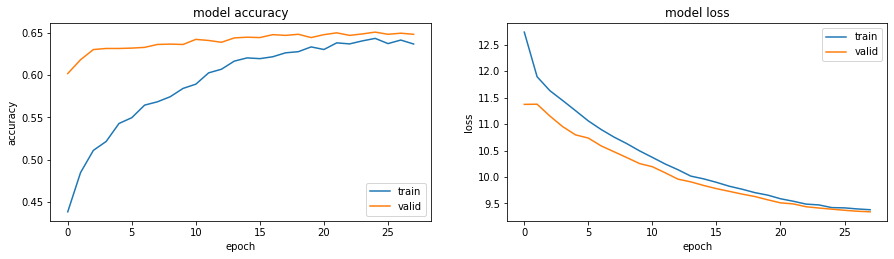


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 2.00e+00 7.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 9.3429 - accuracy: 0.6488

Epoch 1: val_accuracy improved from -inf to 0.54514, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.54514

Epoch 3: val_accuracy improved from 0.54514 to 0.56285, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.56285 to 0.56587, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.56587

Epoch 6: val_accuracy improved from 0.56587 to 0.61641, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.61641 to 0.62808, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.62808 to 0.63153, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.63153

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 10: val_accuracy did not improve from 0.63153

Epoch 11: val_accuracy did not improve from 0.63153
Epoch 11: early s

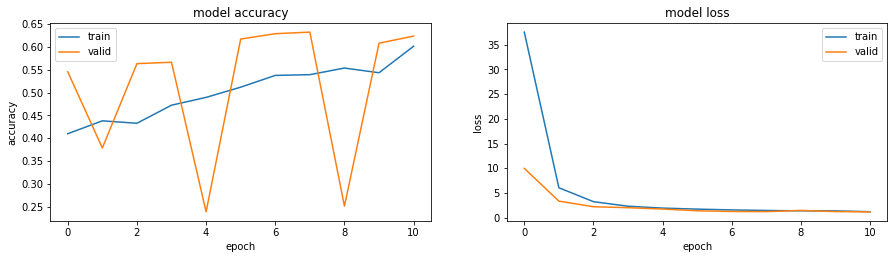


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 3.00e+00 7.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 9.3429 - accuracy: 0.6488

Epoch 1: val_accuracy improved from -inf to 0.53693, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.53693 to 0.54082, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.54082 to 0.54471, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.54471 to 0.54903, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.54903 to 0.56156, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.56156

Epoch 7: val_accuracy improved from 0.56156 to 0.56760, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.56760 to 0.57106, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.57106 to 0.57451, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.57451 to 0.57970, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.57970 to 0.58272, saving mo

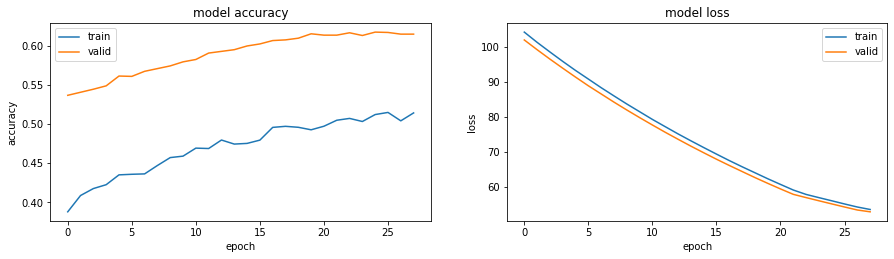


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 1.00e+00 5.00e-01 2.56e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 9.3429 - accuracy: 0.6488

Epoch 1: val_accuracy improved from -inf to 0.50281, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.50281 to 0.52397, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.52397 to 0.52700, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.52700 to 0.53564, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.53564 to 0.53996, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.53996 to 0.54773, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.54773 to 0.55637, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.55637 to 0.56415, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.56415 to 0.56933, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.56933 to 0.58013, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

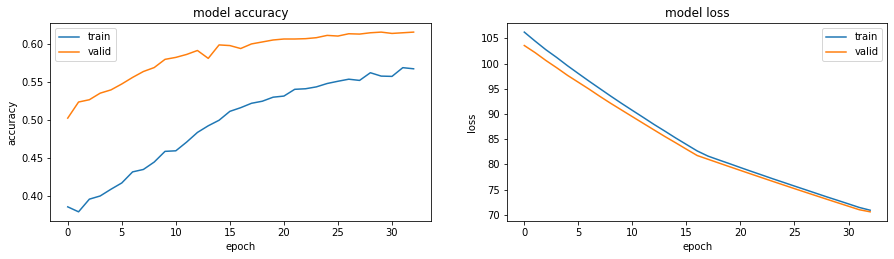


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 1.00e+00 5.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 9.3429 - accuracy: 0.6488

Epoch 1: val_accuracy improved from -inf to 0.60648, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.60648 to 0.61210, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61210 to 0.62635, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.62635

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.62635

Epoch 6: val_accuracy did not improve from 0.62635
Epoch 6: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.1034 - accuracy: 0.6203

LOSS:	1.103406310081482 	 ACCURACY:	0.6203023791313171
[1.103406310081482, 0.6203023791313171]



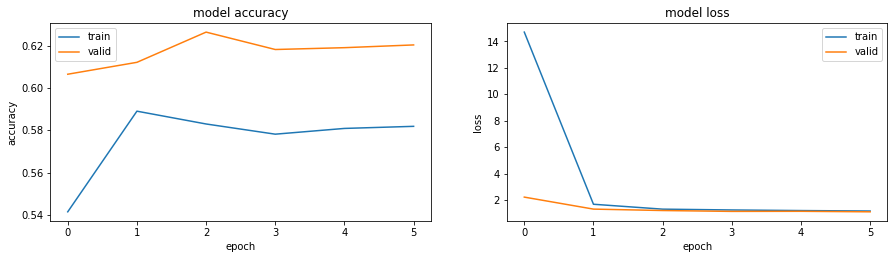


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 1.00e+00 5.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 9.3429 - accuracy: 0.6488

Epoch 1: val_accuracy improved from -inf to 0.52009, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.52009 to 0.53175, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.53175

Epoch 4: val_accuracy improved from 0.53175 to 0.54255, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.54255 to 0.54428, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.54428 to 0.55032, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.55032 to 0.55378, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.55378 to 0.56069, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.56069 to 0.56328, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.56328

Epoch 11: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 11: val_a

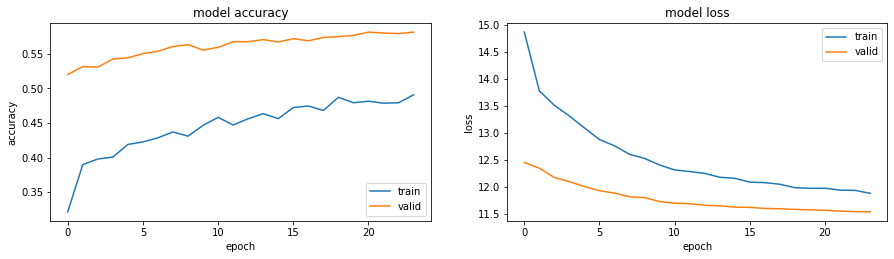


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 2.00e+00 5.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 9.3429 - accuracy: 0.6488

Epoch 1: val_accuracy improved from -inf to 0.60864, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.60864 to 0.63197, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.63197

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.63197

Epoch 5: val_accuracy did not improve from 0.63197
Epoch 5: early stopping
73/73 [==============================] - 0s 4ms/step - loss: 1.4240 - accuracy: 0.4842

LOSS:	1.4240403175354004 	 ACCURACY:	0.4842332601547241
[1.4240403175354004, 0.4842332601547241]



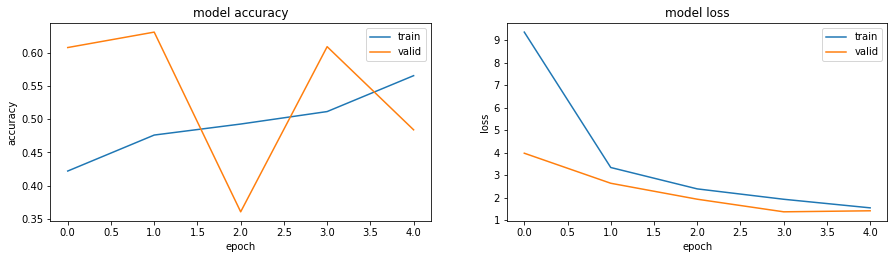


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 3.00e+00 5.00e-01 3.20e+01 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 9.3429 - accuracy: 0.6488

Epoch 1: val_accuracy improved from -inf to 0.55076, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.55076 to 0.56760, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.56760 to 0.58618, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.58618 to 0.60518, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.60518 to 0.61469, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.61469 to 0.61728, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.61728 to 0.62333, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.62333

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 9: val_accuracy did not improve from 0.62333

Epoch 10: val_accuracy did not improve from 0.62333
Epoch 10: early stopping
73/73 [============

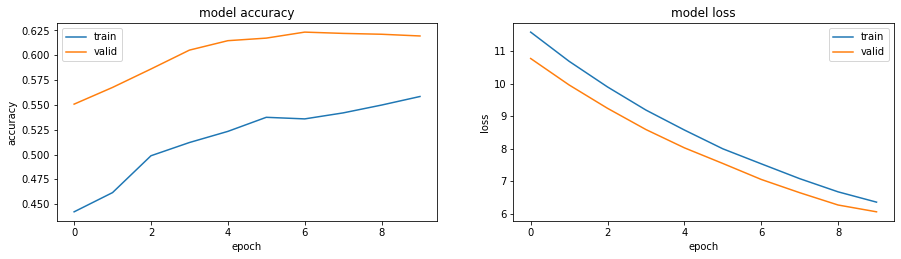


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 3.00e+00 3.00e-01 3.20e+01 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 9.3429 - accuracy: 0.6488

Epoch 1: val_accuracy improved from -inf to 0.53045, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.53045 to 0.54039, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.54039 to 0.54773, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.54773 to 0.55508, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.55508 to 0.56112, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.56112 to 0.56371, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.56371 to 0.56933, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.56933 to 0.57840, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.57840 to 0.58834, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.58834

Epoch 11: ReduceLROnPlateau reducing learning rate to 5.9999998484

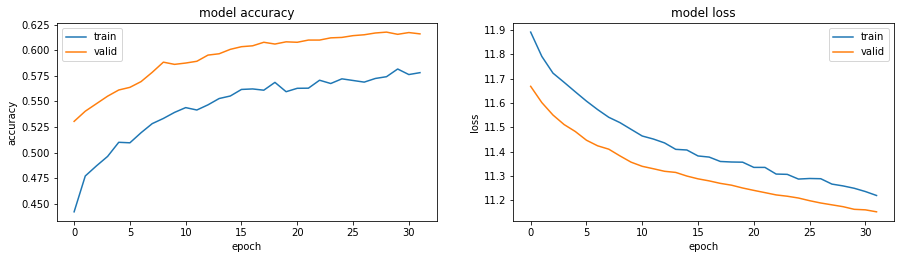


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 1.00e+00 5.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 9.3429 - accuracy: 0.6488

Epoch 1: val_accuracy improved from -inf to 0.17970, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.17970 to 0.24017, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.24017 to 0.32354, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.32354 to 0.39698, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.39698 to 0.44881, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.44881 to 0.47343, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.47343 to 0.48510, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.48510 to 0.49028, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.49028 to 0.49503, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.49503 to 0.49676, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

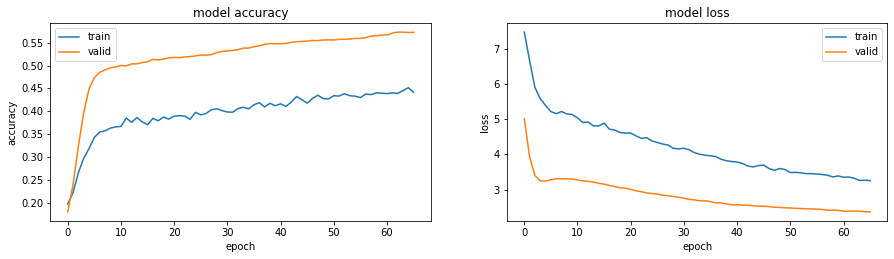


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 1.00e+00 3.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 9.3429 - accuracy: 0.6488

Epoch 1: val_accuracy improved from -inf to 0.49762, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.49762 to 0.51749, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.51749 to 0.53650, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.53650 to 0.54428, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.54428 to 0.56199, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.56199 to 0.56717, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.56717 to 0.58229, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.58229 to 0.58618, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.58618 to 0.59006, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.59006 to 0.59093, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

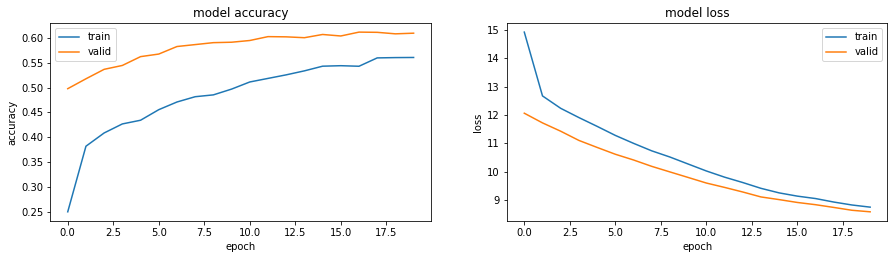


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 2.00e+00 3.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 9.3429 - accuracy: 0.6488

Epoch 1: val_accuracy improved from -inf to 0.04579, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.04579 to 0.06220, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.06220 to 0.13391, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.13391 to 0.23499, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.23499 to 0.33089, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.33089 to 0.39136, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.39136 to 0.43456, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.43456 to 0.45313, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.45313 to 0.46868, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.46868 to 0.48035, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

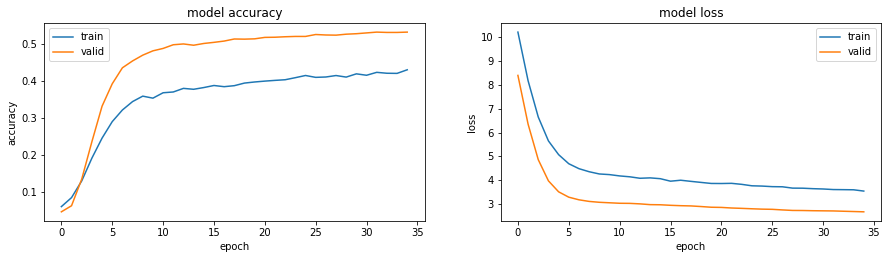


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 2.00e+00 5.00e-01 3.20e+01 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 9.3429 - accuracy: 0.6488

Epoch 1: val_accuracy improved from -inf to 0.53564, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.53564 to 0.58013, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.58013 to 0.59050, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.59050 to 0.59525, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.59525 to 0.60562, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.60562 to 0.60950, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.60950 to 0.61685, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.61685

Epoch 9: val_accuracy improved from 0.61685 to 0.62073, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.62073 to 0.62592, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.62592 to 0.62894, saving mo

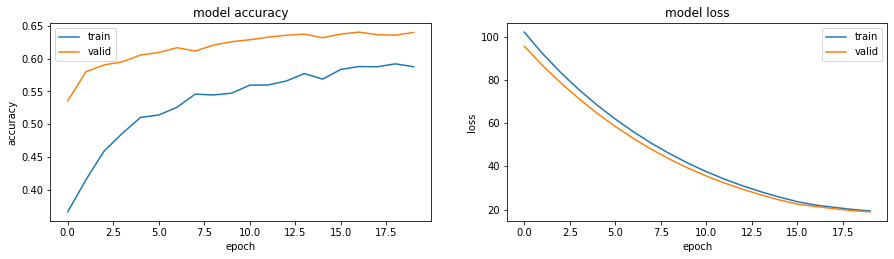


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 1.00e+00 3.00e-01 2.56e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 9.3429 - accuracy: 0.6488

Epoch 1: val_accuracy improved from -inf to 0.55162, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.55162 to 0.55853, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.55853 to 0.59395, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.59395 to 0.61123, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.61123 to 0.61210, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.61210 to 0.62549, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.62549

Epoch 8: val_accuracy improved from 0.62549 to 0.63672, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.63672

Epoch 10: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 10: val_accuracy did not improve from 0.63672

Epoch 11: val_accuracy did not improve fro

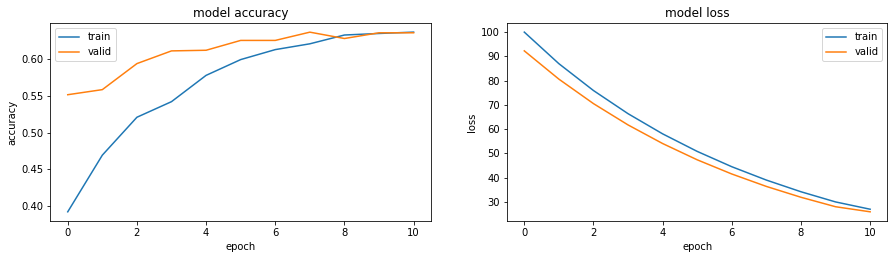


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 3.00e+00 5.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 9.3429 - accuracy: 0.6488

Epoch 1: val_accuracy improved from -inf to 0.50108, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.50108 to 0.51706, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.51706 to 0.52700, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.52700

Epoch 5: val_accuracy improved from 0.52700 to 0.53261, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.53261

Epoch 7: val_accuracy improved from 0.53261 to 0.53737, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.53737 to 0.54125, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.54125 to 0.54168, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.54168 to 0.54514, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.54514

Epoch 12: val_accuracy improved from 0.5

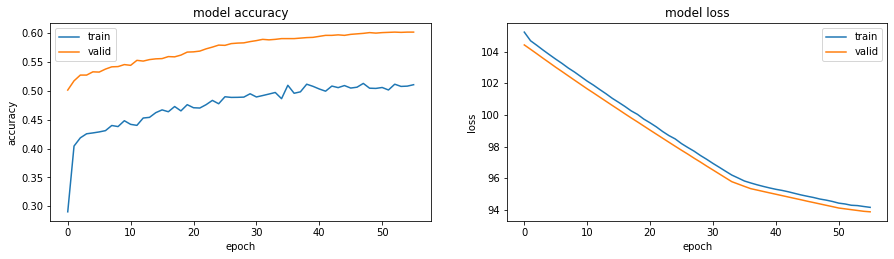


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 2.00e+00 7.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 9.3429 - accuracy: 0.6488

Epoch 1: val_accuracy improved from -inf to 0.58618, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.58618 to 0.63067, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.63067 to 0.63197, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.63197

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.63197

Epoch 6: val_accuracy did not improve from 0.63197
Epoch 6: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.6726 - accuracy: 0.6013

LOSS:	1.6726256608963013 	 ACCURACY:	0.6012958884239197
[1.6726256608963013, 0.6012958884239197]



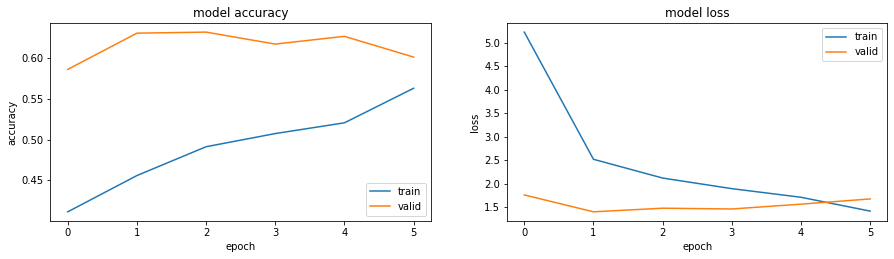


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 2.00e+00 7.00e-01 2.56e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 9.3429 - accuracy: 0.6488

Epoch 1: val_accuracy improved from -inf to 0.54082, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54082 to 0.57235, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.57235 to 0.58747, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.58747 to 0.59870, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.59870 to 0.60259, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.60259

Epoch 7: val_accuracy improved from 0.60259 to 0.60562, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.60562 to 0.60950, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.60950 to 0.61339, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.61339 to 0.61512, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.61512 to 0.61641, saving mo

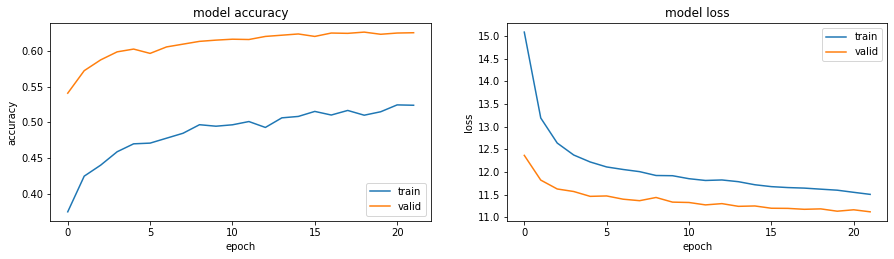


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 1.00e+00 7.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 9.3429 - accuracy: 0.6488

Epoch 1: val_accuracy improved from -inf to 0.54514, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54514 to 0.61253, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.61253

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.61253

Epoch 5: val_accuracy improved from 0.61253 to 0.62505, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.62505

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 7: val_accuracy did not improve from 0.62505

Epoch 8: val_accuracy did not improve from 0.62505
Epoch 8: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.1321 - accuracy: 0.6095

LOSS:	1.1321489810943604 	 ACCURACY:	0.6095032691955566
[1.132148981

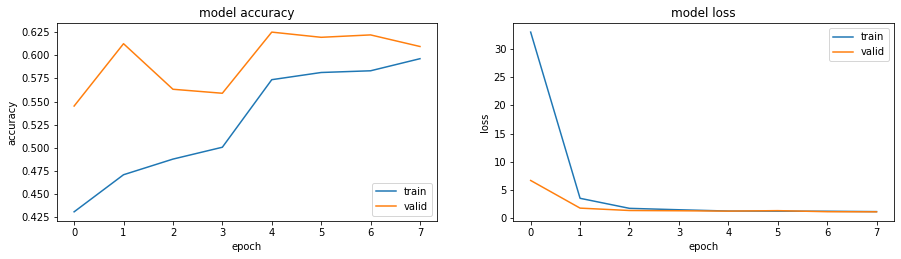


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-02 3.00e+00 5.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 9.3429 - accuracy: 0.6488

Epoch 1: val_accuracy improved from -inf to 0.14989, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.14989 to 0.27905, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.27905 to 0.40173, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.40173 to 0.47862, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.47862 to 0.50972, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.50972 to 0.52009, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.52009 to 0.52441, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.52441 to 0.53132, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.53132 to 0.53261, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.53261 to 0.53477, saving model to DR.h5

Epoch 11: val_accuracy did not improve 

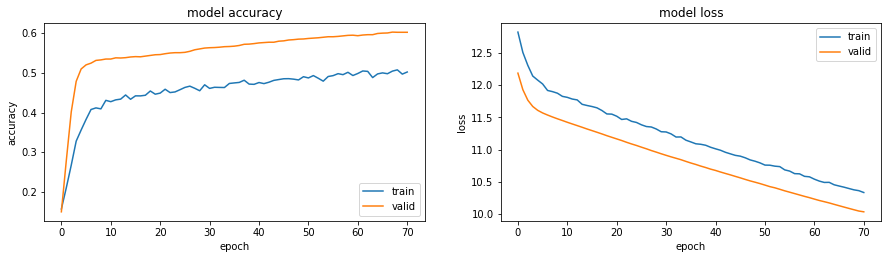


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 1.00e+00 5.00e-01 2.56e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 9.3429 - accuracy: 0.6488

Epoch 1: val_accuracy improved from -inf to 0.59352, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.59352

Epoch 3: val_accuracy improved from 0.59352 to 0.62117, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.62117

Epoch 5: val_accuracy improved from 0.62117 to 0.62721, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.62721

Epoch 7: val_accuracy improved from 0.62721 to 0.63413, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.63413 to 0.63629, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.63629 to 0.63672, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.63672

Epoch 11: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 11: val_accuracy did not improve from 0.63672

Epoch 12: val_ac

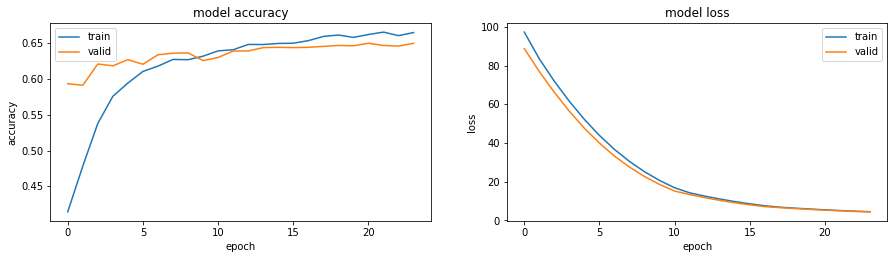


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 3.00e+00 5.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 4.4849 - accuracy: 0.6501

Epoch 1: val_accuracy improved from -inf to 0.14255, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.14255 to 0.14860, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.14860 to 0.16760, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.16760 to 0.22376, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.22376 to 0.32268, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.32268 to 0.40043, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.40043 to 0.45356, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.45356 to 0.48985, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.48985 to 0.50583, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.50583 to 0.50799, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

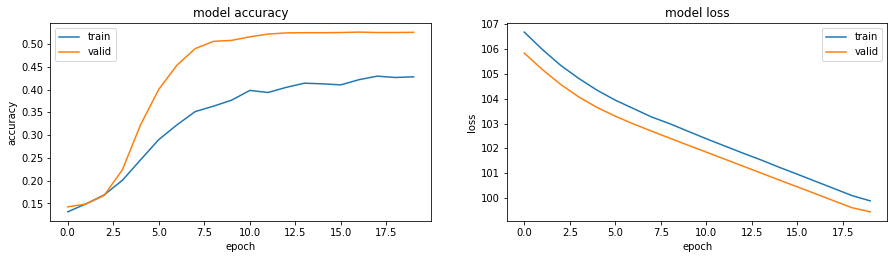


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 1.00e+00 3.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 4.4849 - accuracy: 0.6501

Epoch 1: val_accuracy improved from -inf to 0.05659, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.05659 to 0.12527, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.12527 to 0.31706, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.31706 to 0.43888, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.43888 to 0.48423, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.48423 to 0.49330, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.49330 to 0.49719, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.49719 to 0.50108, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.50108

Epoch 10: val_accuracy improved from 0.50108 to 0.50281, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.50281 to 0.51058, saving mo

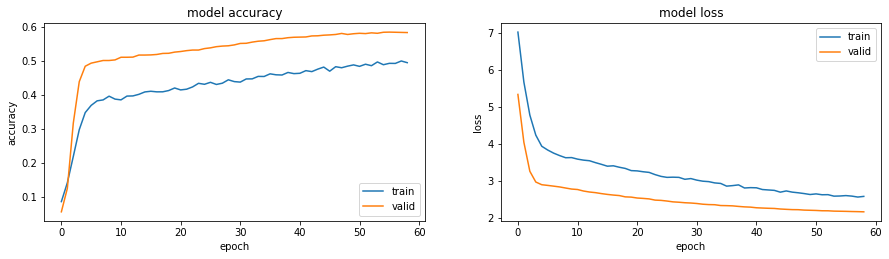


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 3.00e+00 3.00e-01 3.20e+01 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 4.4849 - accuracy: 0.6501

Epoch 1: val_accuracy improved from -inf to 0.46134, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.46134 to 0.51620, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.51620 to 0.52613, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.52613

Epoch 5: val_accuracy improved from 0.52613 to 0.53045, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.53045 to 0.53477, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.53477 to 0.53650, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.53650 to 0.53823, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.53823 to 0.54298, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.54298 to 0.54514, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.54514 to 0.55076, saving mo

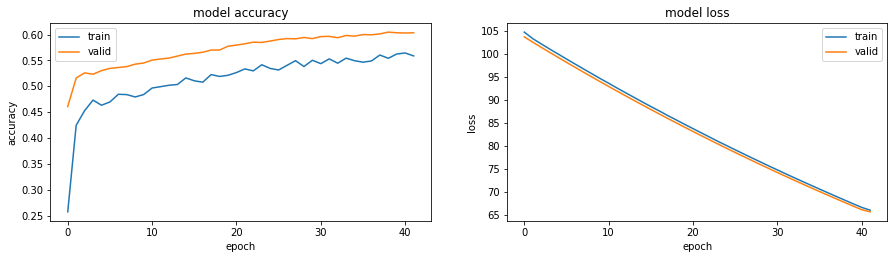


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 1.00e+00 7.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 4.4849 - accuracy: 0.6501

Epoch 1: val_accuracy improved from -inf to 0.56544, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.56544 to 0.62765, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.62765

Epoch 4: val_accuracy improved from 0.62765 to 0.62808, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.62808

Epoch 6: val_accuracy improved from 0.62808 to 0.62981, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.62981

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 8: val_accuracy did not improve from 0.62981

Epoch 9: val_accuracy improved from 0.62981 to 0.63283, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.63283

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 11: val_accur

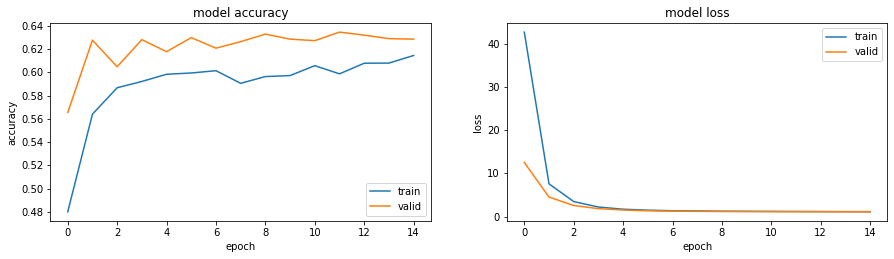


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 1.00e+00 3.00e-01 2.56e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 4.4849 - accuracy: 0.6501

Epoch 1: val_accuracy improved from -inf to 0.42721, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.42721 to 0.50194, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.50194 to 0.50670, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.50670

Epoch 5: val_accuracy improved from 0.50670 to 0.51490, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.51490 to 0.52268, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.52268 to 0.52786, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.52786 to 0.53261, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.53261 to 0.54039, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.54039 to 0.55551, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.55551 to 0.56112, saving mo

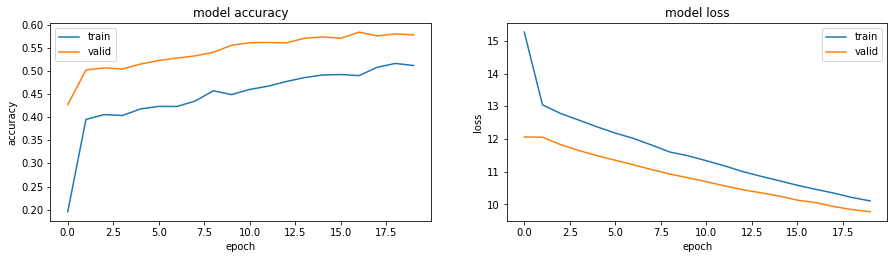


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 3.00e+00 5.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 4.4849 - accuracy: 0.6501

Epoch 1: val_accuracy improved from -inf to 0.60994, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.60994 to 0.61382, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61382 to 0.63110, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.63110 to 0.63283, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.63283 to 0.64104, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.64104

Epoch 7: val_accuracy improved from 0.64104 to 0.65270, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.65270

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 9: val_accuracy did not improve from 0.65270

Epoch 10: val_accuracy did not improve from 0.65270
Epoch 10: early stopping
73/73 [==============================] - 0s 3m

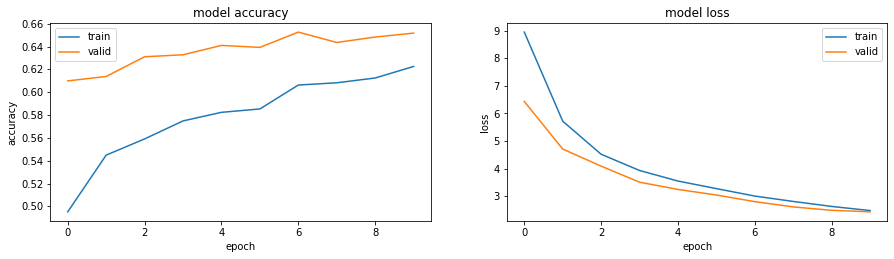


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 2.00e+00 7.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 2.4357 - accuracy: 0.6518

Epoch 1: val_accuracy improved from -inf to 0.59827, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.59827 to 0.61987, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61987 to 0.62894, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.62894 to 0.63067, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.63067 to 0.63499, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.63499 to 0.63801, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.63801

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 8: val_accuracy did not improve from 0.63801

Epoch 9: val_accuracy improved from 0.63801 to 0.64449, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.64449 to 0.64838, saving model to DR.h5

Epoch 11: val_ac

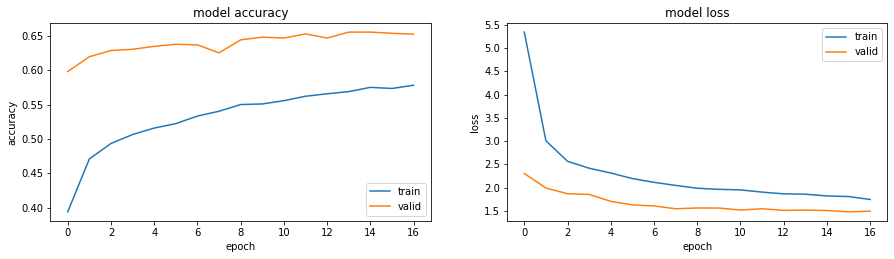


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 2.00e+00 7.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.62462, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.62462

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.62462

Epoch 4: val_accuracy improved from 0.62462 to 0.62678, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.62678

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 6: val_accuracy did not improve from 0.62678

Epoch 7: val_accuracy improved from 0.62678 to 0.63283, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.63283 to 0.63542, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.63542

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00021600000327453016.

Epoch 10: val_accurac

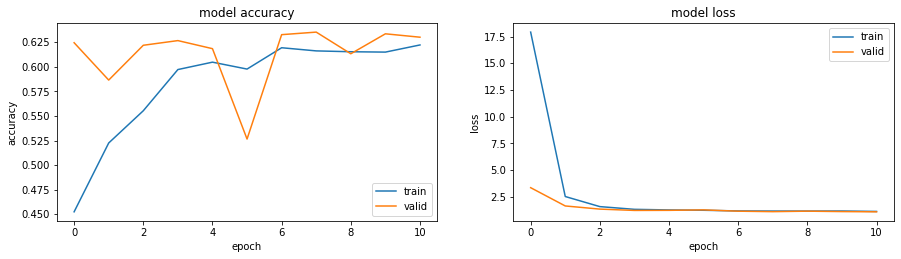


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 2.00e+00 3.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.58056, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.58056 to 0.59482, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.59482 to 0.62419, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.62419 to 0.63110, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.63110 to 0.63326, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.63326

Epoch 7: val_accuracy improved from 0.63326 to 0.64104, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.64104

Epoch 9: val_accuracy improved from 0.64104 to 0.65227, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.65227

Epoch 11: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 11: val_accuracy did not improve fro

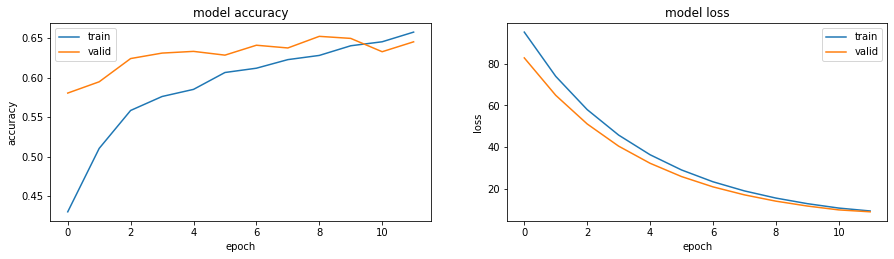


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 2.00e+00 7.00e-01 2.56e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.51404, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.51404 to 0.59179, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.59179 to 0.61641, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.61641 to 0.61728, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.61728 to 0.62160, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.62160 to 0.62678, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.62678

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 8: val_accuracy did not improve from 0.62678

Epoch 9: val_accuracy did not improve from 0.62678
Epoch 9: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 29.1881 - accuracy: 0.6173

LOSS:	29.18

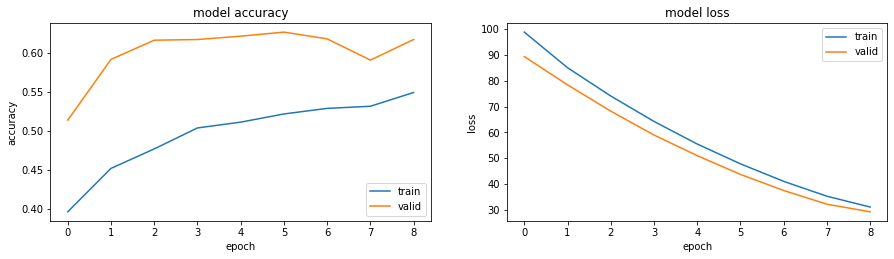


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 2.00e+00 7.00e-01 2.56e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.54514, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54514 to 0.61425, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61425 to 0.61944, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.61944

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.61944

Epoch 6: val_accuracy improved from 0.61944 to 0.63672, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.63672

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 8: val_accuracy did not improve from 0.63672

Epoch 9: val_accuracy did not improve from 0.63672
Epoch 9: early stopping
73/73 [==============================] - 0s 4ms/step - loss: 1.6206 - accurac

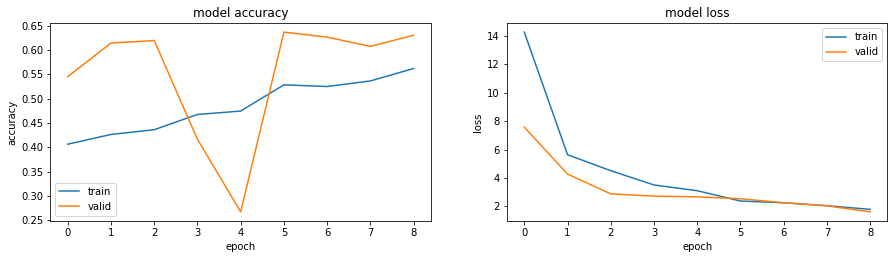


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 2.00e+00 5.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.60130, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.60130 to 0.62333, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.62333 to 0.62592, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.62592 to 0.63369, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.63369 to 0.64665, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.64665

Epoch 7: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 7: val_accuracy did not improve from 0.64665

Epoch 8: val_accuracy improved from 0.64665 to 0.65313, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.65313

Epoch 10: val_accuracy improved from 0.65313 to 0.65659, saving model to DR.h5

Epoch 11: val_accuracy did not improve from

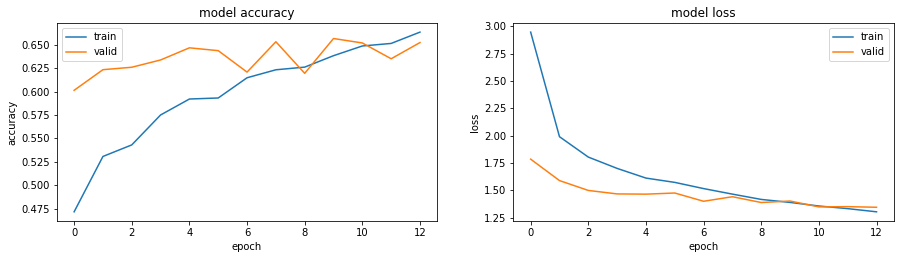


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 3.00e+00 3.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.31706, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.31706 to 0.43585, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.43585 to 0.48596, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.48596 to 0.50281, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.50281 to 0.50842, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.50842 to 0.50972, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.50972 to 0.51274, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.51274 to 0.51490, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.51490

Epoch 10: val_accuracy improved from 0.51490 to 0.51706, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.51706 to 0.52009, saving mo

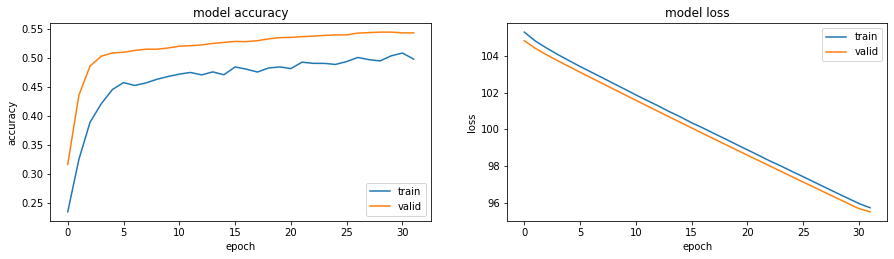


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 1.00e+00 7.00e-01 2.56e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.57365, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.57365 to 0.60994, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.60994

Epoch 4: val_accuracy improved from 0.60994 to 0.61641, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.61641 to 0.62505, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.62505 to 0.63067, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.63067

Epoch 8: val_accuracy improved from 0.63067 to 0.63326, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.63326 to 0.63542, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.63542 to 0.64104, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.64104

Epoch 12: ReduceLROnPlateau reducing lea

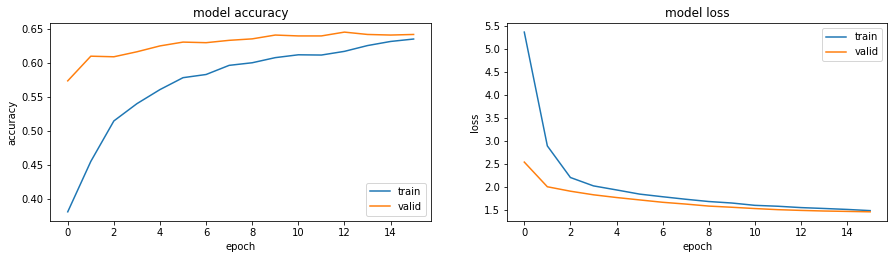


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 3.00e+00 5.00e-01 2.56e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.53607, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.53607 to 0.53866, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.53866 to 0.54168, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.54168 to 0.54514, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.54514 to 0.54903, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.54903 to 0.55292, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.55292 to 0.55767, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.55767 to 0.55940, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.55940 to 0.56415, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.56415 to 0.57235, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

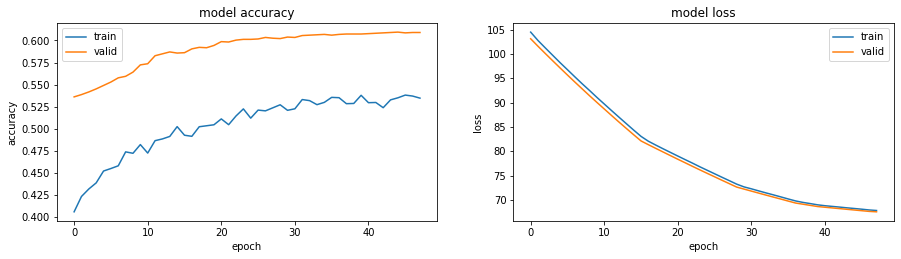


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 2.00e+00 5.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.47775, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.47775 to 0.50108, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.50108 to 0.50886, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.50886 to 0.51274, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.51274

Epoch 6: val_accuracy improved from 0.51274 to 0.51533, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.51533 to 0.51836, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.51836 to 0.52095, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.52095 to 0.52311, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.52311 to 0.52354, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.52354 to 0.52484, saving mo

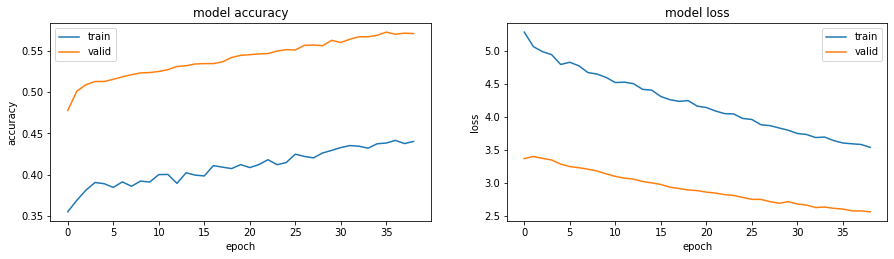


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 3.00e+00 5.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.57970, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.57970

Epoch 3: val_accuracy improved from 0.57970 to 0.62246, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.62246 to 0.62721, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.62721

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.62721

Epoch 7: val_accuracy did not improve from 0.62721
Epoch 7: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 13.0373 - accuracy: 0.6268

LOSS:	13.037282943725586 	 ACCURACY:	0.6267818808555603
[13.037282943725586, 0.6267818808555603]



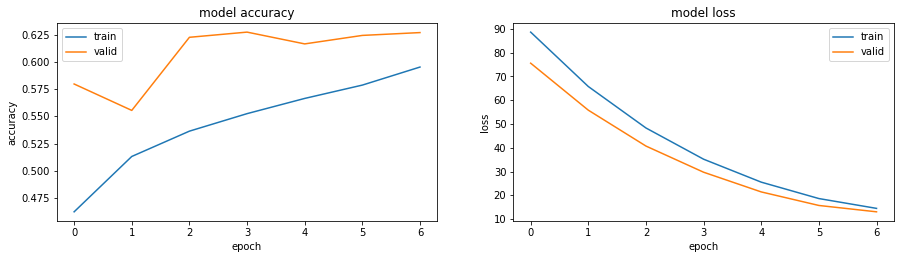


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 3.00e+00 5.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.34860, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.34860 to 0.35119, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.35119 to 0.35637, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.35637 to 0.36415, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.36415 to 0.36803, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.36803 to 0.37063, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.37063 to 0.37711, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.37711 to 0.38056, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.38056 to 0.38575, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.38575 to 0.38920, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

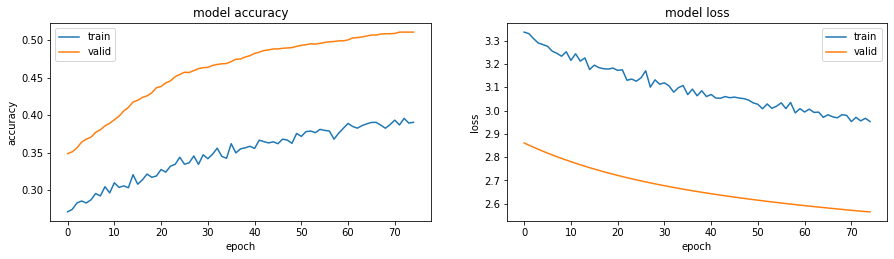


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 1.00e+00 7.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.54687, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54687 to 0.56069, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.56069 to 0.58531, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.58531 to 0.59093, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.59093 to 0.60346, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.60346 to 0.60691, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.60691 to 0.60994, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.60994 to 0.61382, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.61382 to 0.61512, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.61512 to 0.61641, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

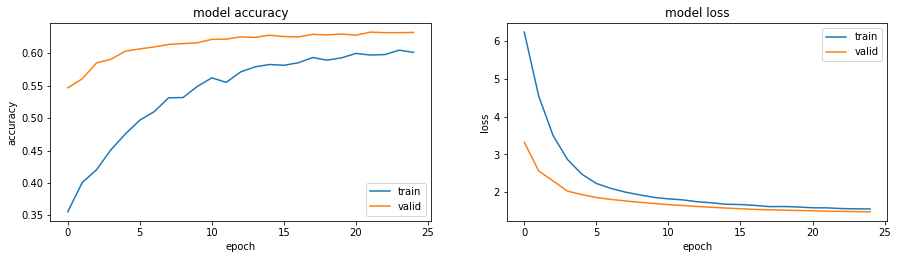


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 1.00e+00 7.00e-01 3.20e+01 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.60432, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.60432

Epoch 3: val_accuracy improved from 0.60432 to 0.60864, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.60864 to 0.61857, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.61857 to 0.63067, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.63067

Epoch 7: val_accuracy improved from 0.63067 to 0.63369, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.63369

Epoch 9: val_accuracy improved from 0.63369 to 0.63456, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.63456 to 0.63542, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.63542

Epoch 12: val_accuracy improved from 0.63542 to 0.63672, saving mod

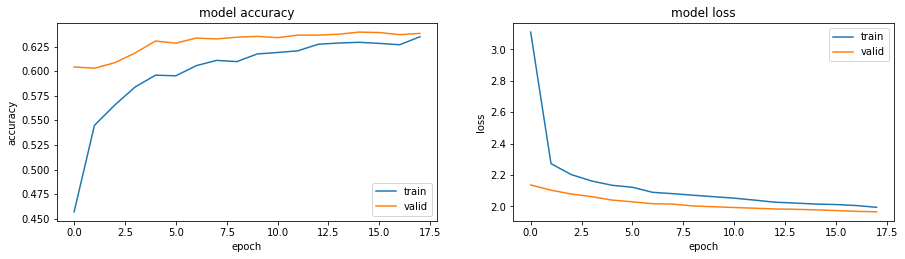


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 2.00e+00 3.00e-01 2.56e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.55248, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.55248 to 0.59611, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.59611

Epoch 4: val_accuracy improved from 0.59611 to 0.61512, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.61512 to 0.62333, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.62333 to 0.62635, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.62635

Epoch 8: val_accuracy improved from 0.62635 to 0.63413, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.63413

Epoch 10: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 10: val_accuracy did not improve from 0.63413

Epoch 11: val_accuracy did not improve from 0.63413
Epoch 11: early s

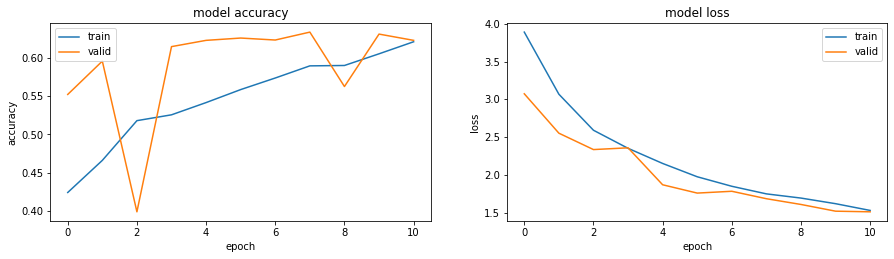


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 3.00e+00 3.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.51965, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.51965 to 0.53089, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.53089 to 0.53477, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.53477 to 0.53737, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.53737 to 0.54212, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.54212 to 0.54600, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.54600 to 0.54903, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.54903 to 0.55076, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.55076

Epoch 10: val_accuracy improved from 0.55076 to 0.55378, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.55378 to 0.55853, saving mo

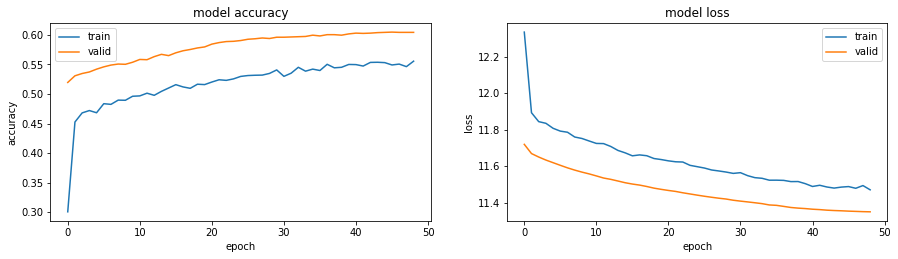


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 3.00e+00 7.00e-01 3.20e+01 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.22030, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.22030 to 0.50583, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.50583 to 0.53650, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.53650 to 0.53996, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.53996 to 0.54082, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.54082 to 0.54212, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.54212

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 8: val_accuracy did not improve from 0.54212

Epoch 9: val_accuracy did not improve from 0.54212
Epoch 9: early stopping
73/73 [==============================] - 0s 4ms/step - loss: 2.4310 - accuracy: 0.5417

LOSS:	2.4310

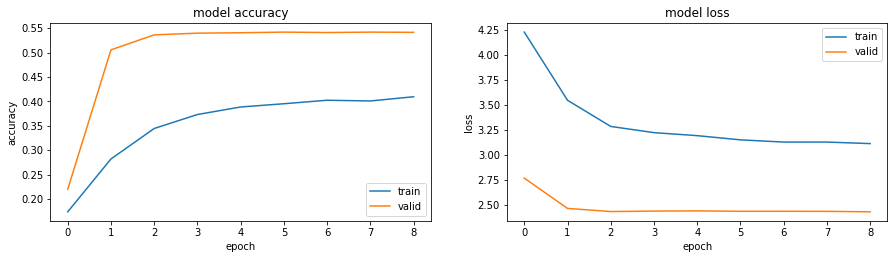


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 2.00e+00 5.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.53477, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.53477 to 0.55378, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.55378 to 0.57019, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.57019 to 0.58402, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.58402 to 0.59093, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.59093 to 0.60086, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.60086 to 0.60346, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.60346 to 0.61296, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.61296

Epoch 10: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 10: val_accuracy did not improve from 0.61296

Epoch 11: val_a

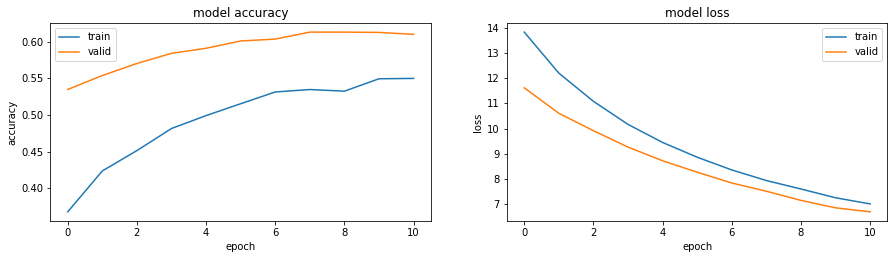


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-01 2.00e+00 3.00e-01 2.56e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.34816, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.34816 to 0.42462, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.42462 to 0.45788, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.45788 to 0.47214, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.47214 to 0.48207, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.48207 to 0.48423, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.48423 to 0.48553, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.48553 to 0.48726, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.48726

Epoch 10: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 10: val_accuracy did not improve from 0.48726

Epoch 11: val_a

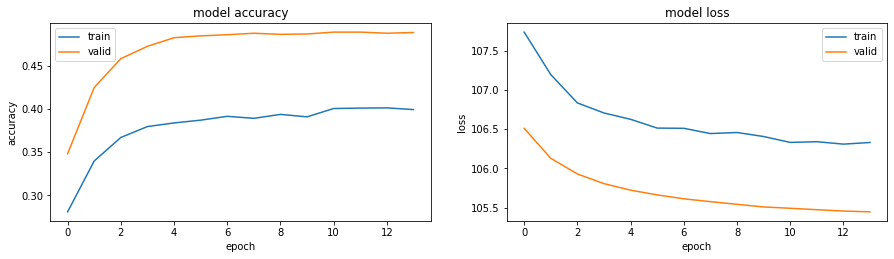


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 2.00e+00 5.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.51749, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.51749 to 0.53650, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.53650 to 0.54816, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.54816 to 0.56631, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.56631 to 0.57797, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.57797 to 0.58186, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.58186 to 0.58445, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.58445 to 0.59525, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.59525 to 0.59784, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.59784 to 0.60130, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

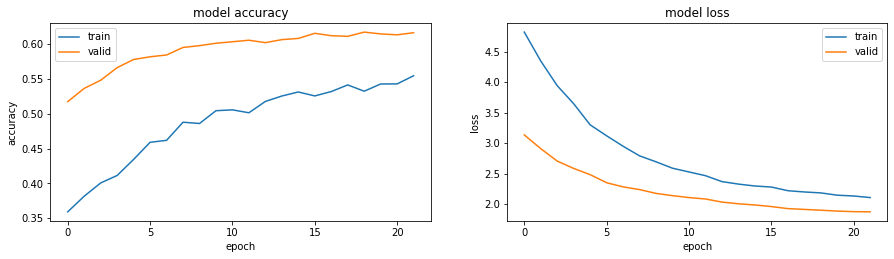


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 3.00e+00 3.00e-01 2.56e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.58704, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.58704 to 0.61210, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61210 to 0.62030, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.62030 to 0.62203, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.62203 to 0.63153, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.63153

Epoch 7: val_accuracy improved from 0.63153 to 0.64147, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.64147 to 0.64320, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.64320

Epoch 10: val_accuracy improved from 0.64320 to 0.64579, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.64579

Epoch 12: ReduceLROnPlateau reducing lea

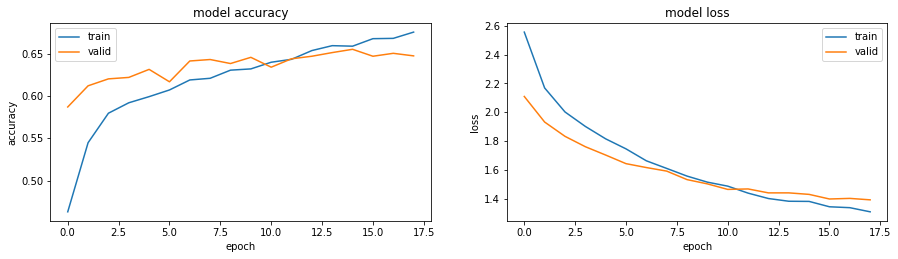


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 7.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.55464, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.55464

Epoch 3: val_accuracy improved from 0.55464 to 0.62203, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.62203

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.62203

Epoch 6: val_accuracy improved from 0.62203 to 0.62765, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.62765 to 0.63672, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.63672 to 0.63715, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.63715 to 0.64492, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.64492

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00036000001709

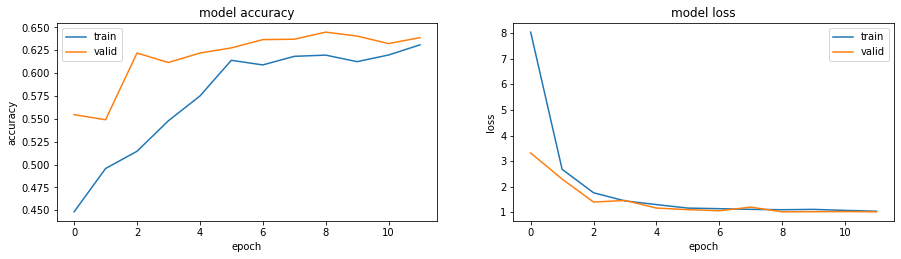


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 2.00e+00 7.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.59093, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.59093 to 0.61814, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61814 to 0.63024, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.63024 to 0.63153, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.63153 to 0.63499, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.63499 to 0.64104, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.64104

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 8: val_accuracy did not improve from 0.64104

Epoch 9: val_accuracy improved from 0.64104 to 0.64492, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.64492 to 0.64579, saving model to DR.h5

Epoch 11: val_ac

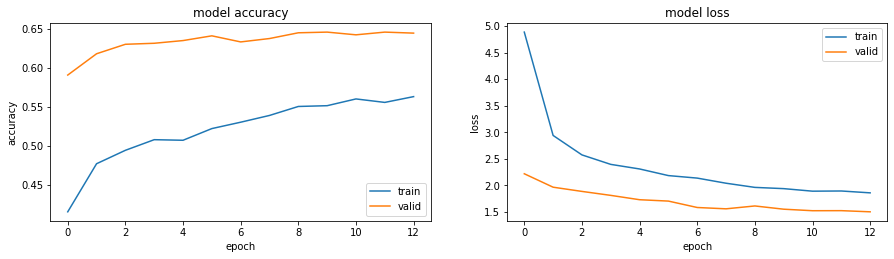


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 3.00e+00 5.00e-01 2.56e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.57711, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.57711 to 0.60518, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.60518

Epoch 4: val_accuracy improved from 0.60518 to 0.62246, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.62246 to 0.62505, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.62505

Epoch 7: val_accuracy improved from 0.62505 to 0.63456, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.63456

Epoch 9: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 9: val_accuracy did not improve from 0.63456

Epoch 10: val_accuracy improved from 0.63456 to 0.63758, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.63758 to 0.63844, saving model 

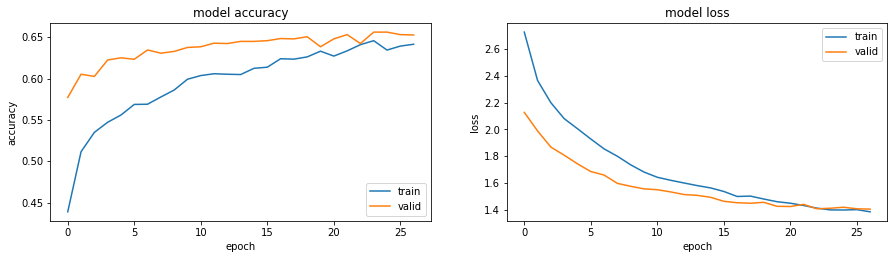


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 3.00e+00 3.00e-01 2.56e+02 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.52181, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.52181 to 0.53909, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.53909 to 0.54816, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.54816 to 0.56026, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.56026 to 0.57149, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.57149 to 0.58315, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.58315

Epoch 8: val_accuracy improved from 0.58315 to 0.59006, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.59006 to 0.59741, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.59741

Epoch 11: val_accuracy improved from 0.59741 to 0.59827, saving model to DR.h5

Epoch 12: val

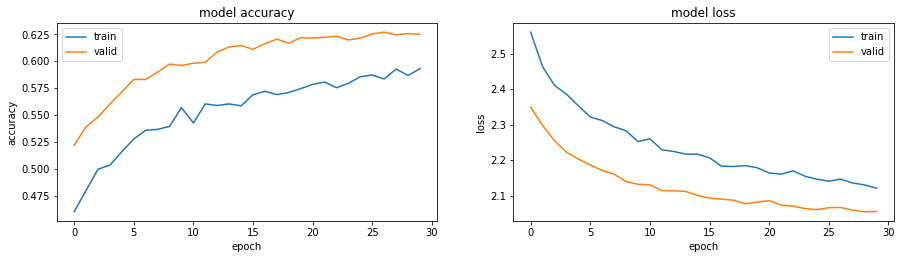


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 2.00e+00 3.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.4914 - accuracy: 0.6527

Epoch 1: val_accuracy improved from -inf to 0.62808, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.62808 to 0.64147, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.64147 to 0.65054, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.65054

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.65054

Epoch 6: val_accuracy improved from 0.65054 to 0.65659, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.65659

Epoch 8: val_accuracy improved from 0.65659 to 0.66307, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.66307

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 10: val_accuracy did not improve from 0.66307

Epoch 11: val_accur

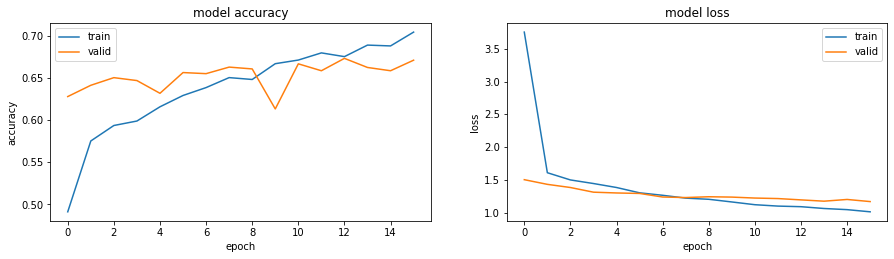


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 2.00e+00 3.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.64017, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.64017

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.64017

Epoch 4: val_accuracy improved from 0.64017 to 0.64536, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.64536

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 6: val_accuracy did not improve from 0.64536

Epoch 7: val_accuracy improved from 0.64536 to 0.66004, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.66004

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.00021600000327453016.

Epoch 9: val_accuracy did not improve from 0.66004

Epoch 10: val_accuracy did not improve from 0.660

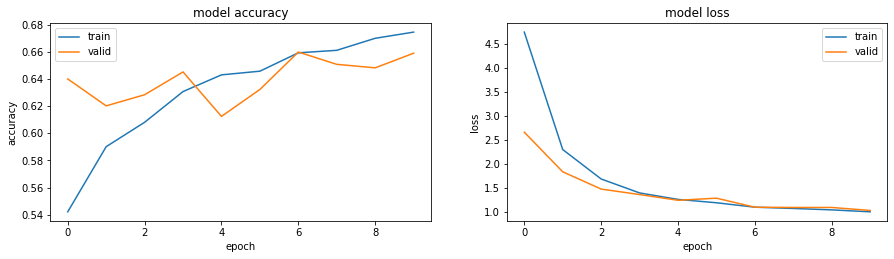


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 2.00e+00 5.00e-01 2.56e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.55464, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.55464 to 0.56415, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.56415 to 0.59093, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.59093

Epoch 5: val_accuracy improved from 0.59093 to 0.59784, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.59784 to 0.61166, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.61166 to 0.61296, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.61296 to 0.61425, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.61425 to 0.61728, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.61728 to 0.62203, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.62203 to 0.62289, saving mo

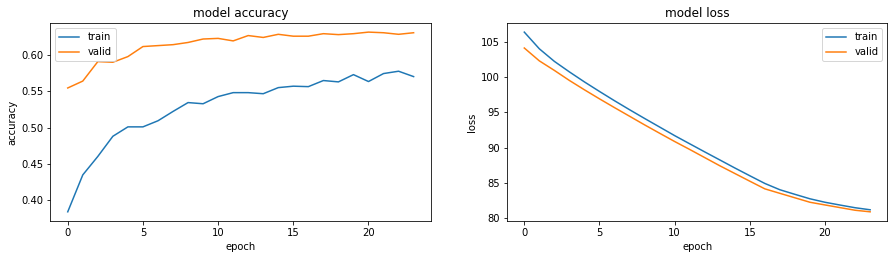


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 3.00e+00 3.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.53175, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.53175 to 0.54557, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.54557

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.54557

Epoch 5: val_accuracy improved from 0.54557 to 0.56501, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.56501 to 0.61339, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.61339 to 0.63110, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.63110

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 9: val_accuracy did not improve from 0.63110

Epoch 10: val_accuracy did not improve from 0.63110
Epoch 10: early stopp

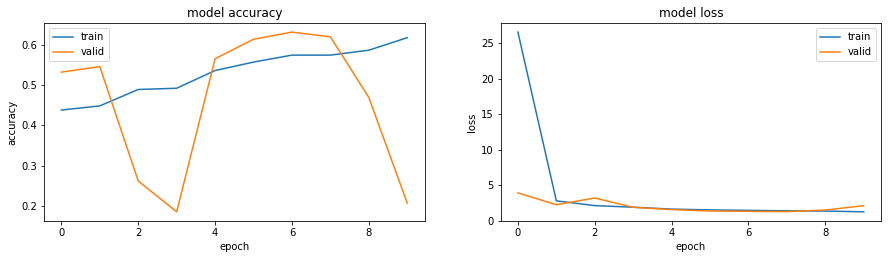


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 3.00e+00 5.00e-01 2.56e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.37365, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.37365 to 0.43456, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.43456 to 0.47084, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.47084 to 0.49503, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.49503 to 0.50972, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.50972 to 0.51663, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.51663 to 0.52052, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.52052 to 0.52268, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.52268 to 0.52441, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.52441 to 0.52484, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

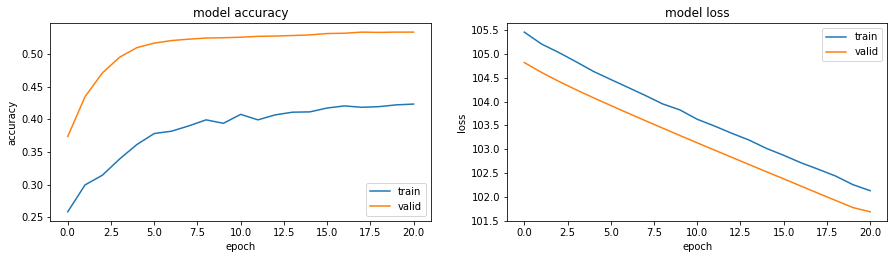


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 1.00e+00 7.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.53952, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.53952 to 0.54255, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.54255 to 0.54644, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.54644 to 0.55032, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.55032 to 0.56587, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.56587 to 0.57624, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.57624 to 0.58315, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.58315 to 0.59784, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.59784 to 0.59870, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.59870 to 0.60216, saving model to DR.h5

Epoch 11: val_accuracy did not improve 

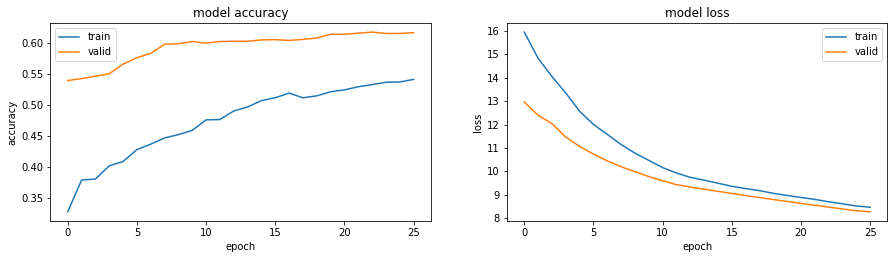


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 1.00e+00 7.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.54428, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54428 to 0.54644, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.54644 to 0.54773, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.54773 to 0.54903, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.54903 to 0.56717, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.56717 to 0.57927, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.57927 to 0.58445, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.58445 to 0.59050, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.59050

Epoch 10: val_accuracy improved from 0.59050 to 0.59438, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.59438 to 0.59957, saving mo

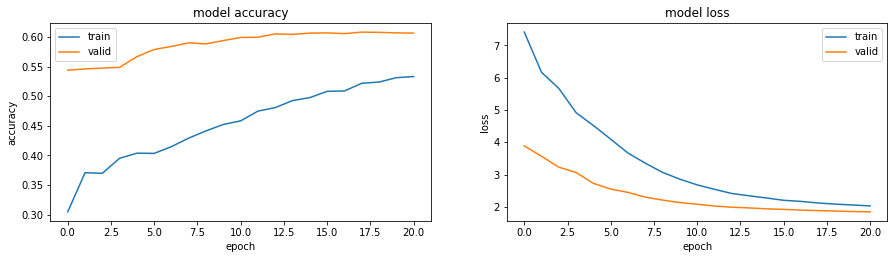


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 2.00e+00 7.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.55983, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.55983 to 0.60994, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.60994 to 0.62721, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.62721 to 0.63801, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.63801

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.63801

Epoch 7: val_accuracy improved from 0.63801 to 0.63931, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.63931

Epoch 9: val_accuracy improved from 0.63931 to 0.64147, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.64147

Epoch 11: ReduceLROnPlateau reducing learning rate to 3.59999990905635

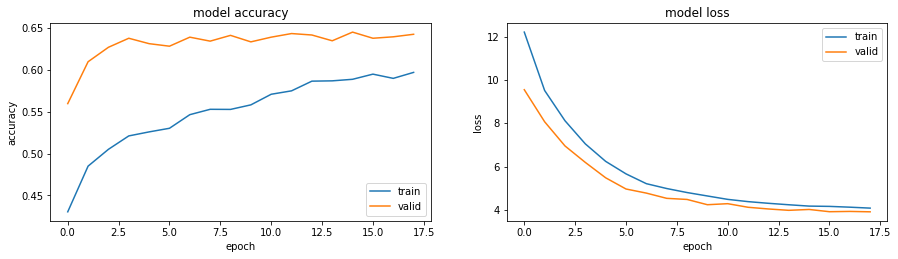


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 3.00e+00 5.00e-01 2.56e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.47689, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.47689 to 0.52225, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.52225 to 0.53132, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.53132

Epoch 5: val_accuracy improved from 0.53132 to 0.53434, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.53434

Epoch 7: val_accuracy improved from 0.53434 to 0.53521, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.53521 to 0.53650, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.53650 to 0.53737, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.53737 to 0.53780, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.53780 to 0.54039, saving model to DR.h5

Epoch 12: val

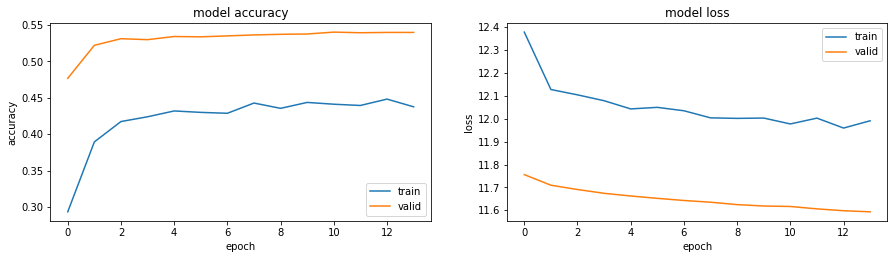


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 3.00e+00 7.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.39741, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.39741 to 0.51879, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.51879 to 0.53737, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.53737 to 0.53823, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.53823 to 0.54082, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.54082 to 0.54168, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.54168 to 0.54298, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.54298 to 0.54557, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.54557

Epoch 10: ReduceLROnPlateau reducing learning rate to 5.999999984851456e-07.

Epoch 10: val_accuracy did not improve from 0.54557

Epoch 11: val_a

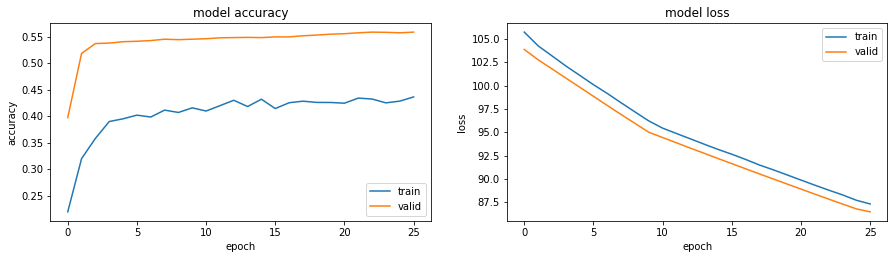


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 2.00e+00 7.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.54816, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54816 to 0.56156, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.56156

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.56156

Epoch 5: val_accuracy improved from 0.56156 to 0.62117, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.62117 to 0.62592, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.62592

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 8: val_accuracy did not improve from 0.62592

Epoch 9: val_accuracy did not improve from 0.62592
Epoch 9: early stopping
73/73 [==============================] - 0s 4ms/step - loss: 1.4312 - accurac

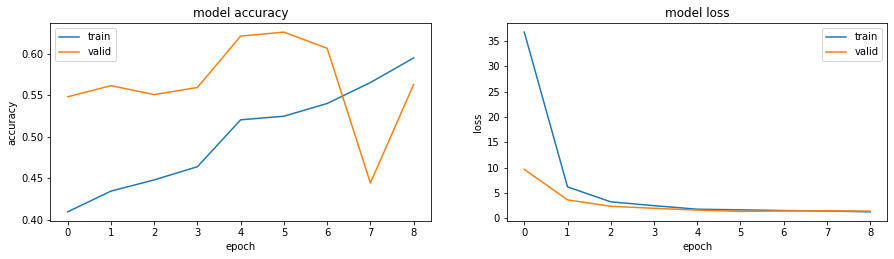


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 3.00e+00 3.00e-01 2.56e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.54644, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54644 to 0.62635, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.62635 to 0.62678, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.62678 to 0.63715, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.63715 to 0.64363, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.64363

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 7: val_accuracy did not improve from 0.64363

Epoch 8: val_accuracy improved from 0.64363 to 0.64752, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.64752 to 0.64881, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.64881

Epoch 11: val_accuracy improved from 0.6488

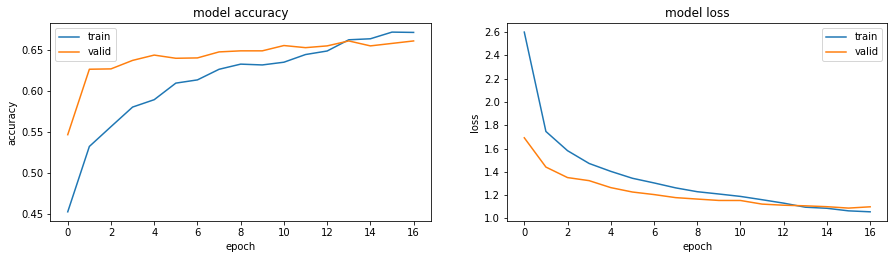


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 2.00e+00 3.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.53866, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.53866 to 0.59266, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.59266

Epoch 4: val_accuracy improved from 0.59266 to 0.59482, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.59482 to 0.60302, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.60302

Epoch 7: val_accuracy improved from 0.60302 to 0.60994, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.60994 to 0.61857, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.61857 to 0.62203, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.62203

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 11: val_accuracy did not improve fro

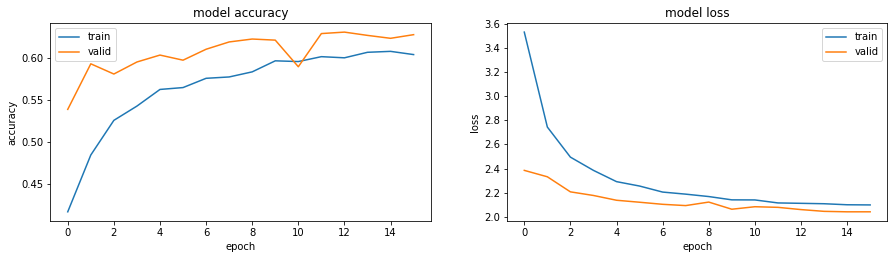


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 3.00e+00 3.00e-01 3.20e+01 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.24838, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.24838 to 0.59093, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.59093

Epoch 4: val_accuracy improved from 0.59093 to 0.63888, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.63888 to 0.63931, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.63931

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 7: val_accuracy did not improve from 0.63931

Epoch 8: val_accuracy improved from 0.63931 to 0.64579, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.64579 to 0.64708, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.64708

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.00036000001709

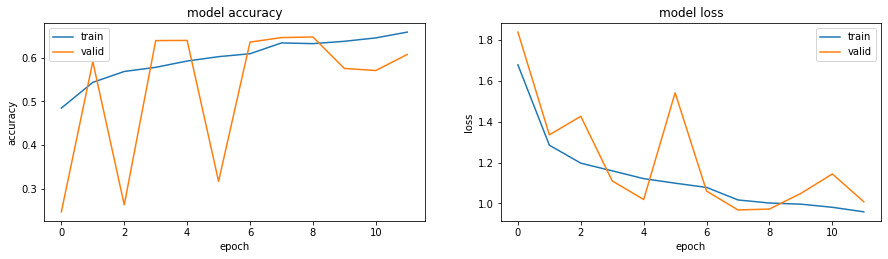


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 3.00e+00 3.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.54946, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54946 to 0.57495, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.57495 to 0.59525, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.59525 to 0.60734, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.60734 to 0.61641, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.61641 to 0.61944, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.61944 to 0.62246, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.62246 to 0.62333, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.62333 to 0.62592, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.62592 to 0.62981, saving model to DR.h5

Epoch 11: val_accuracy did not improve 

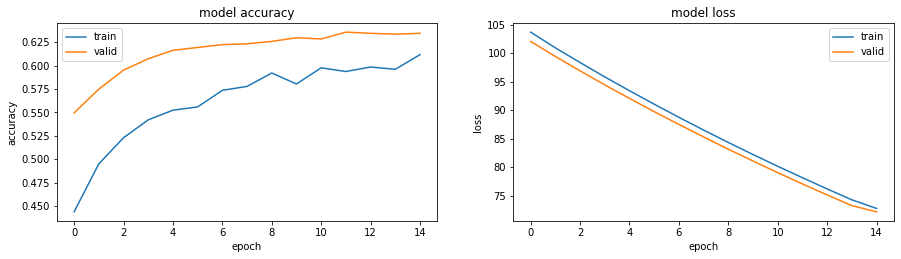


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 3.00e+00 5.00e-01 2.56e+02 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.52570, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.52570 to 0.53002, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.53002 to 0.53996, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.53996 to 0.55767, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.55767 to 0.56458, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.56458 to 0.57408, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.57408 to 0.58143, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.58143 to 0.58877, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.58877 to 0.59352, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.59352 to 0.59482, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

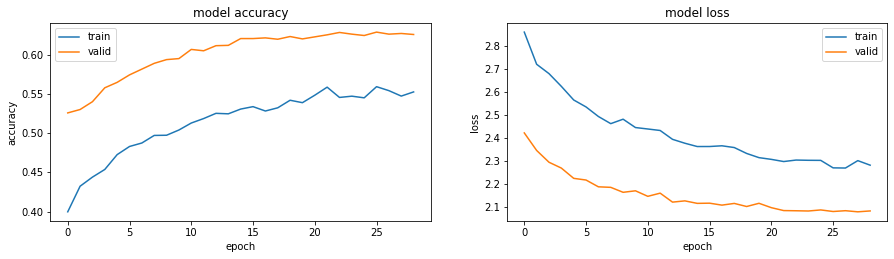


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 3.00e+00 3.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.59266, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.59266

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 3: val_accuracy did not improve from 0.59266

Epoch 4: val_accuracy improved from 0.59266 to 0.63715, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.63715

Epoch 6: ReduceLROnPlateau reducing learning rate to 3.599999909056351e-05.

Epoch 6: val_accuracy did not improve from 0.63715

Epoch 7: val_accuracy did not improve from 0.63715
Epoch 7: early stopping
73/73 [==============================] - 0s 4ms/step - loss: 1.4594 - accuracy: 0.6246

LOSS:	1.4593844413757324 	 ACCURACY:	0.6246220469474792
[1.4593844413757324, 0.6246220469474792]



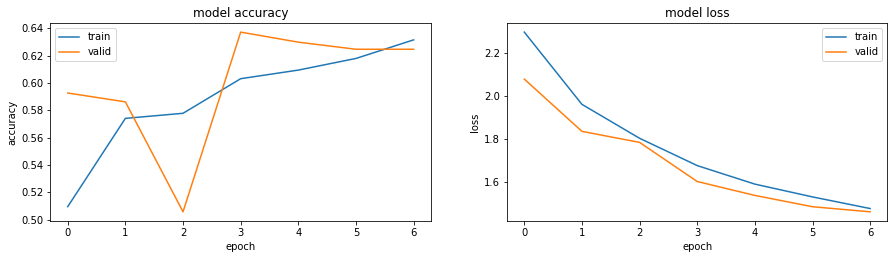


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 3.00e+00 5.00e-01 3.20e+01 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.59093, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.59093 to 0.61512, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.61512

Epoch 4: val_accuracy improved from 0.61512 to 0.62851, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.62851

Epoch 6: val_accuracy improved from 0.62851 to 0.62981, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.62981 to 0.63283, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.63283 to 0.63326, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.63326 to 0.63585, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.63585

Epoch 11: val_accuracy improved from 0.63585 to 0.64017, saving model to DR.h5

Epoch 12: val_accuracy did not improve f

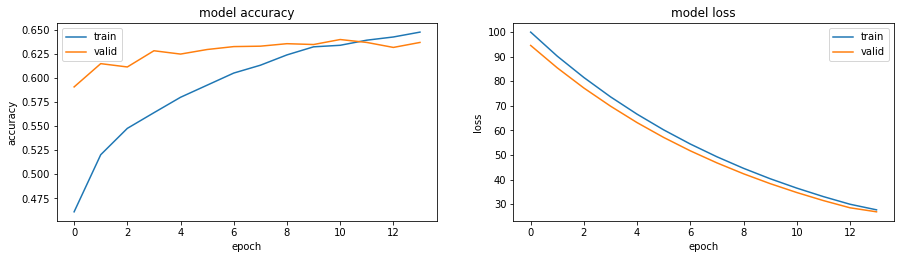


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-01 3.00e+00 7.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.55896, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.55896 to 0.56976, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.56976 to 0.58834, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.58834

Epoch 5: val_accuracy improved from 0.58834 to 0.60346, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.60346

Epoch 7: val_accuracy improved from 0.60346 to 0.61425, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.61425

Epoch 9: val_accuracy improved from 0.61425 to 0.62030, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.62030

Epoch 11: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 11: val_accuracy did not improve from 0.62030

Epoch 12: val_ac

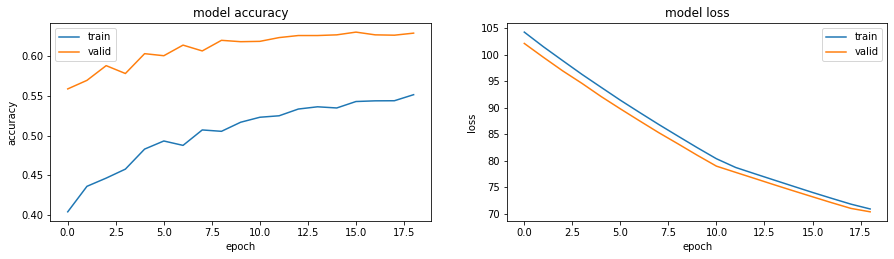


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 3.00e+00 5.00e-01 3.20e+01 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.52441, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.52441 to 0.52959, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.52959 to 0.54168, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.54168 to 0.54860, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.54860 to 0.55853, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.55853 to 0.56544, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.56544 to 0.57711, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.57711 to 0.58272, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.58272 to 0.58488, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.58488 to 0.58618, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

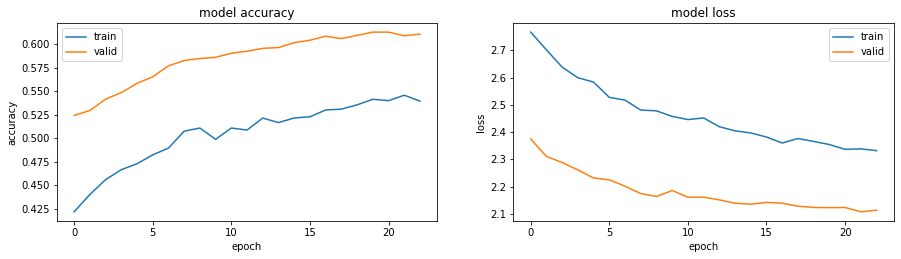


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 5.00e-01 3.20e+01 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.60389, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.60389 to 0.61296, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61296 to 0.62721, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.62721 to 0.62981, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.62981

Epoch 6: val_accuracy improved from 0.62981 to 0.63326, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.63326

Epoch 8: val_accuracy improved from 0.63326 to 0.63542, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.63542

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 10: val_accuracy did not improve from 0.63542

Epoch 11: val_accuracy improved from 0.63542 to 0.63715, saving model

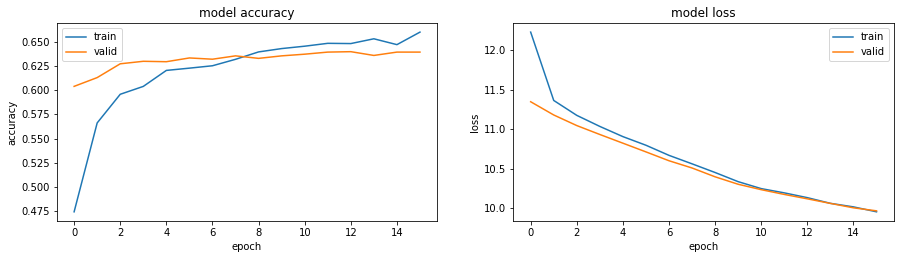


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 3.00e+00 5.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.61685, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.61685 to 0.61771, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61771 to 0.62894, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.62894

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 5: val_accuracy did not improve from 0.62894

Epoch 6: val_accuracy did not improve from 0.62894
Epoch 6: early stopping
73/73 [==============================] - 0s 3ms/step - loss: 1.1278 - accuracy: 0.6199

LOSS:	1.1277709007263184 	 ACCURACY:	0.6198704242706299
[1.1277709007263184, 0.6198704242706299]



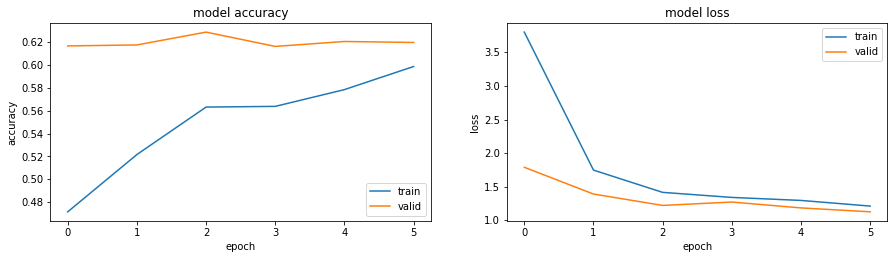


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 2.00e+00 7.00e-01 3.20e+01 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.61382, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.61382

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 3: val_accuracy did not improve from 0.61382

Epoch 4: val_accuracy improved from 0.61382 to 0.63931, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.63931

Epoch 6: val_accuracy improved from 0.63931 to 0.64363, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.64363

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 8: val_accuracy did not improve from 0.64363

Epoch 9: val_accuracy did not improve from 0.64363
Epoch 9: early stopping
73/73 [==============================] - 0s 4ms/step - loss: 1.2079 - accuracy: 0.6350

LOSS:	1.20788514

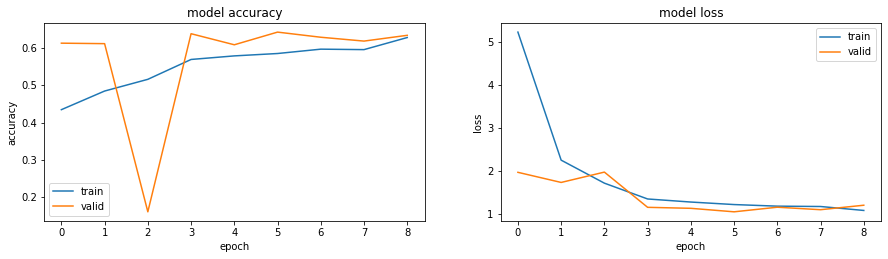


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-03 1.00e+00 3.00e-01 2.56e+02 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.47732, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.47732 to 0.61080, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61080 to 0.61469, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.61469

Epoch 5: val_accuracy improved from 0.61469 to 0.61944, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.61944 to 0.62678, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.62678 to 0.63542, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.63542

Epoch 9: val_accuracy improved from 0.63542 to 0.63888, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.63888

Epoch 11: val_accuracy improved from 0.63888 to 0.64579, saving model to DR.h5

Epoch 12: val_accuracy improved from 0.6

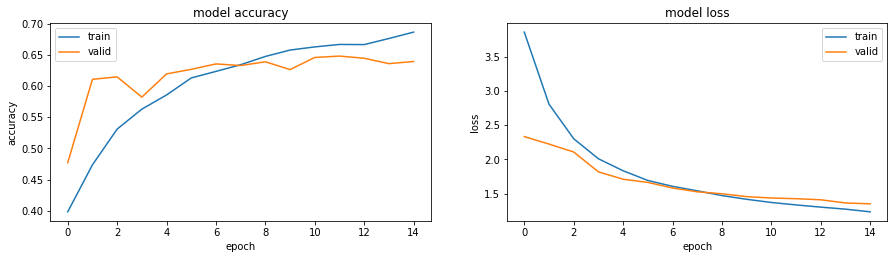


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 1.00e+00 7.00e-01 3.20e+01 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.54644, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54644 to 0.56587, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.56587 to 0.57581, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.57581 to 0.58877, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.58877 to 0.59352, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.59352 to 0.59827, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.59827 to 0.60259, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.60259

Epoch 9: val_accuracy improved from 0.60259 to 0.60562, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.60562 to 0.60950, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.60950

Epoch 12: val

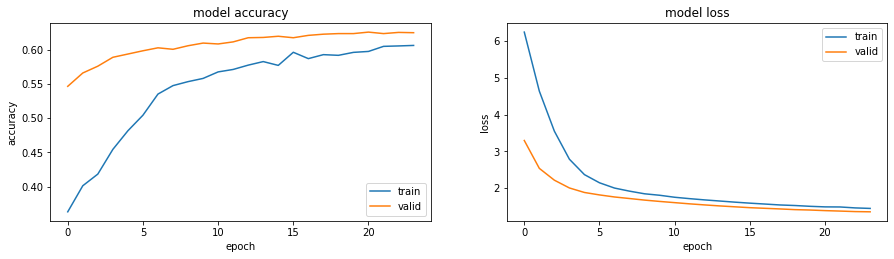


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 2.00e+00 5.00e-01 2.56e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.52959, saving model to DR.h5

Epoch 2: val_accuracy did not improve from 0.52959

Epoch 3: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 3: val_accuracy did not improve from 0.52959

Epoch 4: val_accuracy improved from 0.52959 to 0.53261, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.53261 to 0.53650, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.53650 to 0.54039, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.54039 to 0.54514, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.54514 to 0.55119, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.55119 to 0.55637, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.55637 to 0.56285, saving model to DR.h5

Epoch 11: val_ac

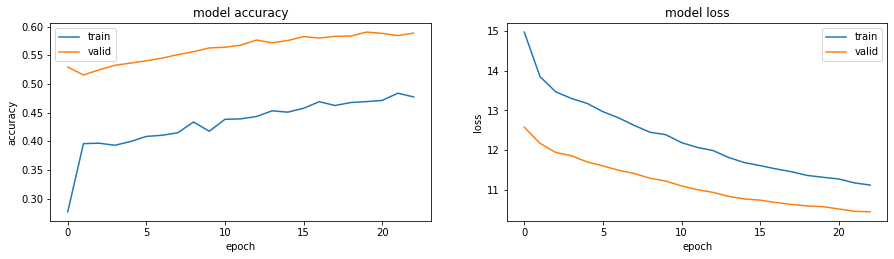


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-01 2.00e+00 3.00e-01 3.20e+01 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.44708, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.44708 to 0.49719, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.49719 to 0.50410, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.50410 to 0.50886, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.50886 to 0.51447, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.51447 to 0.52052, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.52052 to 0.52095, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.52095 to 0.52138, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.52138 to 0.52916, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.52916 to 0.53089, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

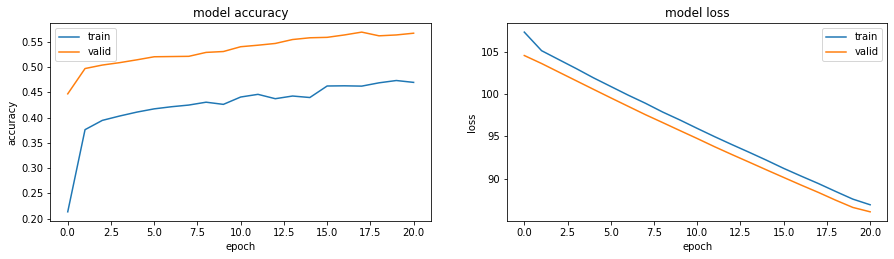


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 1.00e+00 3.00e-01 2.56e+02 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.09330, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.09330 to 0.10065, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.10065 to 0.10972, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.10972 to 0.12009, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.12009 to 0.13132, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.13132 to 0.14082, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.14082 to 0.15421, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.15421 to 0.16890, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.16890 to 0.18531, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.18531 to 0.20778, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

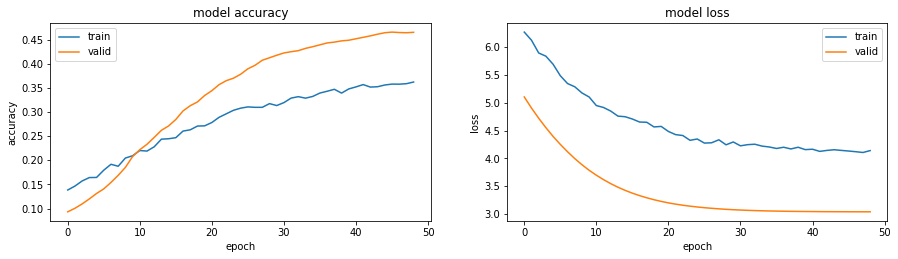


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-01 1.00e+00 3.00e-01 2.56e+02 3.00e+00]]
73/73 [==============================] - 0s 3ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.45356, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.45356 to 0.48985, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.48985 to 0.60000, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.60000 to 0.61728, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.61728 to 0.62894, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.62894 to 0.63413, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.63413

Epoch 8: val_accuracy improved from 0.63413 to 0.63974, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.63974

Epoch 10: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 10: val_accuracy did not improve from 0.63974

Epoch 11: val_accuracy improved from 0.639

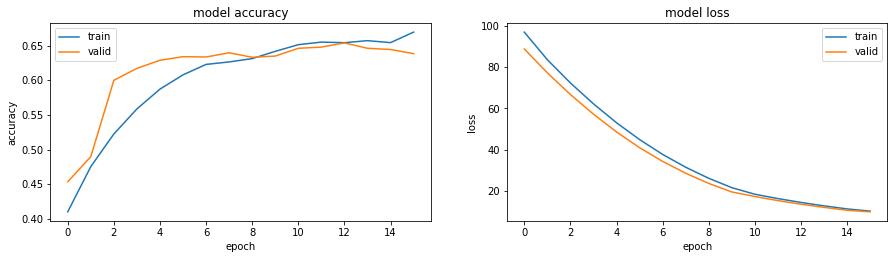


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 2.00e+00 7.00e-01 1.28e+02 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.56371, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.56371 to 0.58272, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.58272 to 0.60734, saving model to DR.h5

Epoch 4: val_accuracy did not improve from 0.60734

Epoch 5: val_accuracy improved from 0.60734 to 0.62246, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.62246

Epoch 7: val_accuracy improved from 0.62246 to 0.62289, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.62289 to 0.62981, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.62981 to 0.63110, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.63110 to 0.63585, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.63585

Epoch 12: val_accuracy improved from 0.6

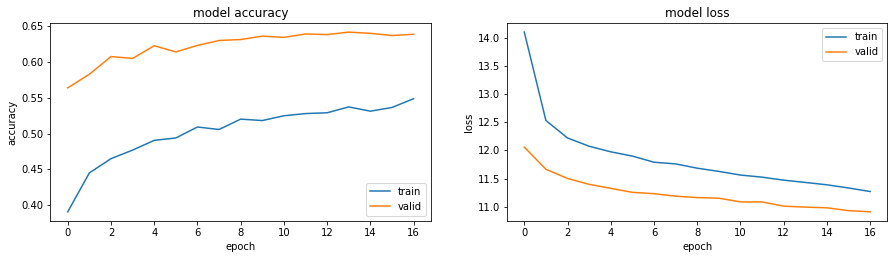


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 3.00e+00 3.00e-01 3.20e+01 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.57451, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.57451 to 0.61339, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.61339

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.61339

Epoch 5: val_accuracy improved from 0.61339 to 0.62246, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.62246

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003600000170990825.

Epoch 7: val_accuracy did not improve from 0.62246

Epoch 8: val_accuracy improved from 0.62246 to 0.62808, saving model to DR.h5

Epoch 9: val_accuracy did not improve from 0.62808

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00021600000327453016.

Epoch 10: val_accurac

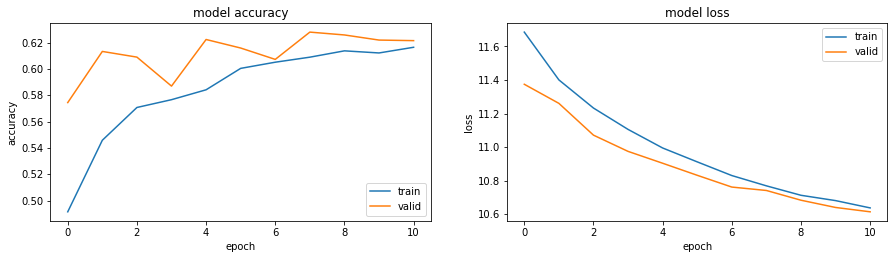


Hyperparameters: [[5.12e+02 1.00e-06 1.00e-03 3.00e+00 3.00e-01 3.20e+01 2.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.16976, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.16976 to 0.17279, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.17279 to 0.17408, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.17408 to 0.17538, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.17538 to 0.18099, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.18099 to 0.19395, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.19395 to 0.20950, saving model to DR.h5

Epoch 8: val_accuracy improved from 0.20950 to 0.22635, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.22635 to 0.24881, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.24881 to 0.27991, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.

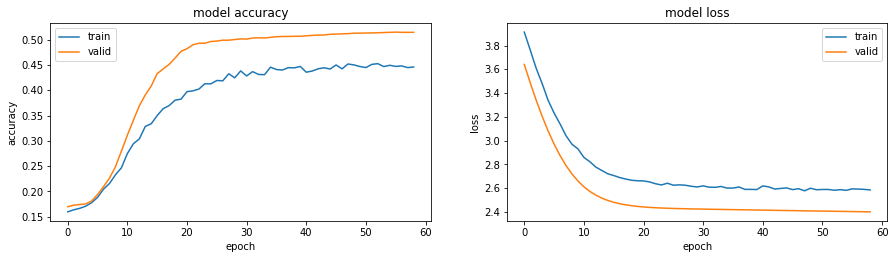


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 3.00e+00 7.00e-01 3.20e+01 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.53996, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.53996 to 0.54989, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.54989 to 0.56674, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.56674 to 0.58099, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.58099 to 0.59222, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.59222 to 0.60302, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.60302 to 0.60778, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.60778

Epoch 9: val_accuracy improved from 0.60778 to 0.60907, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.60907 to 0.61425, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.61425 to 0.61512, saving mo

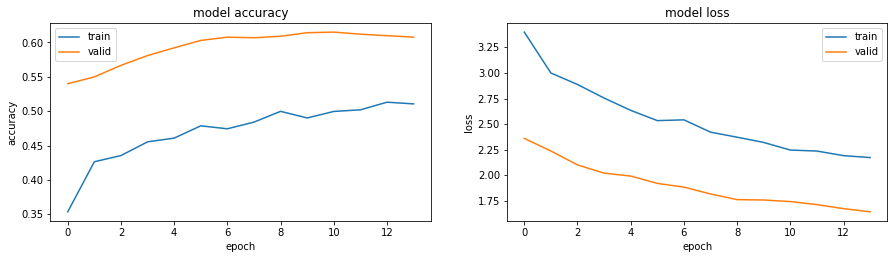


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 3.00e-01 1.28e+02 3.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.54471, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.54471 to 0.60994, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.60994

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.60994

Epoch 5: val_accuracy improved from 0.60994 to 0.62981, saving model to DR.h5

Epoch 6: val_accuracy did not improve from 0.62981

Epoch 7: val_accuracy improved from 0.62981 to 0.63456, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.63456

Epoch 9: val_accuracy improved from 0.63456 to 0.64276, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.64276 to 0.64838, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.64838

Epoch 12: ReduceL

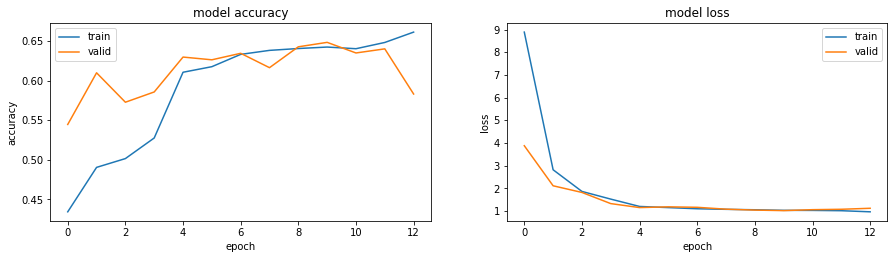


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 1.00e+00 5.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.52268, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.52268 to 0.53823, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.53823 to 0.54341, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.54341 to 0.55853, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.55853 to 0.56803, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.56803 to 0.58272, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.58272

Epoch 8: val_accuracy improved from 0.58272 to 0.58704, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.58704 to 0.59827, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.59827 to 0.60346, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.60346

Epoch 12: Red

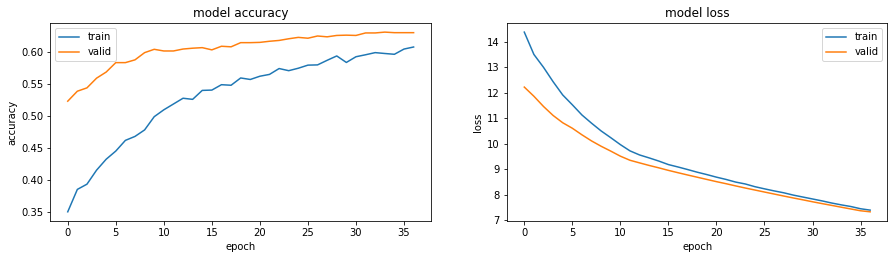


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-02 1.00e+00 7.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.60562, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.60562 to 0.60907, saving model to DR.h5

Epoch 3: val_accuracy did not improve from 0.60907

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.

Epoch 4: val_accuracy did not improve from 0.60907

Epoch 5: val_accuracy did not improve from 0.60907
Epoch 5: early stopping
73/73 [==============================] - 0s 4ms/step - loss: 1.2330 - accuracy: 0.5737

LOSS:	1.2329596281051636 	 ACCURACY:	0.5736501216888428
[1.2329596281051636, 0.5736501216888428]



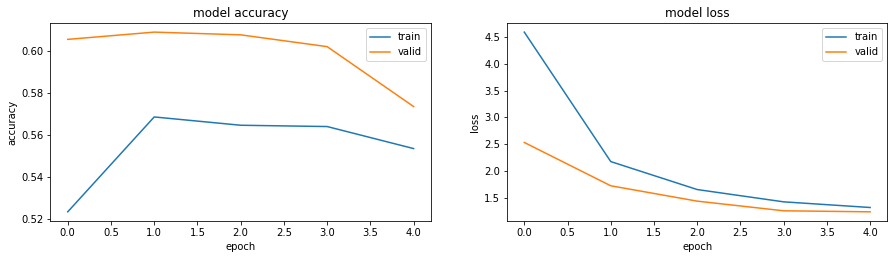


Hyperparameters: [[5.12e+02 1.00e-03 1.00e-03 1.00e+00 5.00e-01 2.56e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.57711, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.57711 to 0.61944, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61944 to 0.63024, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.63024 to 0.63283, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.63283 to 0.64017, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.64017 to 0.64147, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.64147

Epoch 8: val_accuracy improved from 0.64147 to 0.64190, saving model to DR.h5

Epoch 9: val_accuracy improved from 0.64190 to 0.64838, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.64838 to 0.65443, saving model to DR.h5

Epoch 11: val_accuracy did not improve from 0.65443

Epoch 12: val

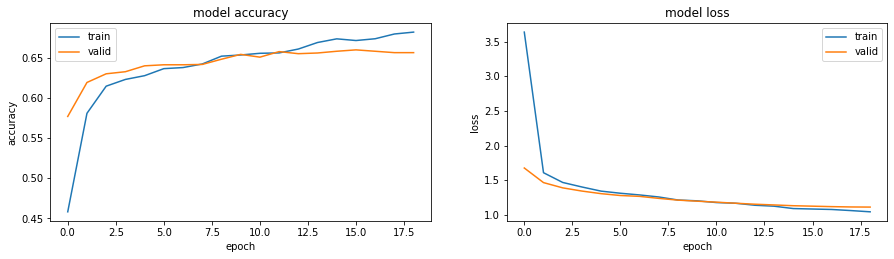


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-02 2.00e+00 3.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.45486, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.45486 to 0.48207, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.48207 to 0.48769, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.48769 to 0.51663, saving model to DR.h5

Epoch 5: val_accuracy improved from 0.51663 to 0.53737, saving model to DR.h5

Epoch 6: val_accuracy improved from 0.53737 to 0.55119, saving model to DR.h5

Epoch 7: val_accuracy improved from 0.55119 to 0.56847, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.56847

Epoch 9: val_accuracy improved from 0.56847 to 0.57063, saving model to DR.h5

Epoch 10: val_accuracy improved from 0.57063 to 0.57754, saving model to DR.h5

Epoch 11: val_accuracy improved from 0.57754 to 0.59309, saving mo

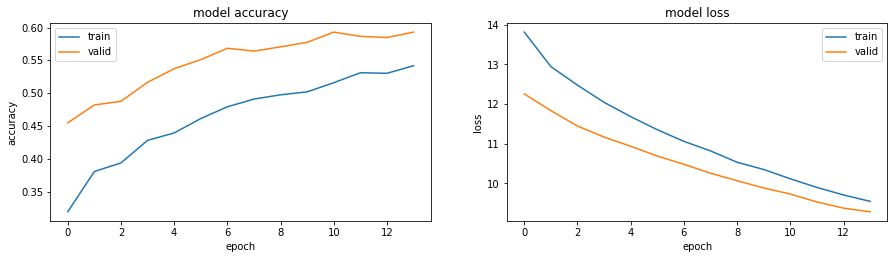


Hyperparameters: [[5.12e+02 1.00e-05 1.00e-03 3.00e+00 3.00e-01 3.20e+01 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.56587, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.56587 to 0.59957, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.59957 to 0.60778, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.60778 to 0.61771, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.61771

Epoch 6: val_accuracy improved from 0.61771 to 0.62117, saving model to DR.h5

Epoch 7: val_accuracy did not improve from 0.62117

Epoch 8: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-06.

Epoch 8: val_accuracy did not improve from 0.62117

Epoch 9: val_accuracy improved from 0.62117 to 0.62246, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.62246

Epoch 11: ReduceLROnPlateau reducing learning rate to 3.59999985448666

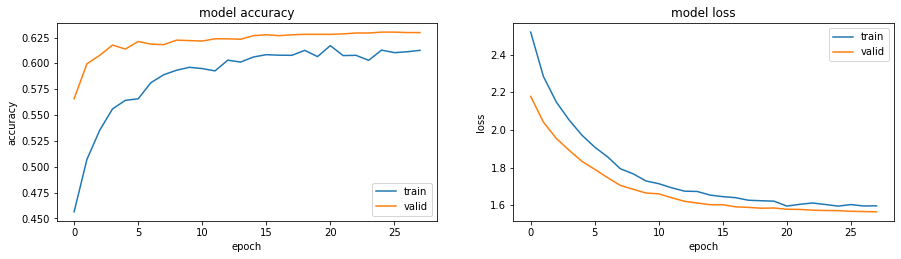


Hyperparameters: [[5.12e+02 1.00e-04 1.00e-02 1.00e+00 3.00e-01 1.28e+02 1.00e+00]]
73/73 [==============================] - 0s 4ms/step - loss: 1.1757 - accuracy: 0.6713

Epoch 1: val_accuracy improved from -inf to 0.57667, saving model to DR.h5

Epoch 2: val_accuracy improved from 0.57667 to 0.61728, saving model to DR.h5

Epoch 3: val_accuracy improved from 0.61728 to 0.62678, saving model to DR.h5

Epoch 4: val_accuracy improved from 0.62678 to 0.63456, saving model to DR.h5

Epoch 5: val_accuracy did not improve from 0.63456

Epoch 6: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 6: val_accuracy did not improve from 0.63456

Epoch 7: val_accuracy improved from 0.63456 to 0.63974, saving model to DR.h5

Epoch 8: val_accuracy did not improve from 0.63974

Epoch 9: val_accuracy improved from 0.63974 to 0.64363, saving model to DR.h5

Epoch 10: val_accuracy did not improve from 0.64363

Epoch 11: ReduceLROnPlateau reducing learning rate to 3.59999990905635

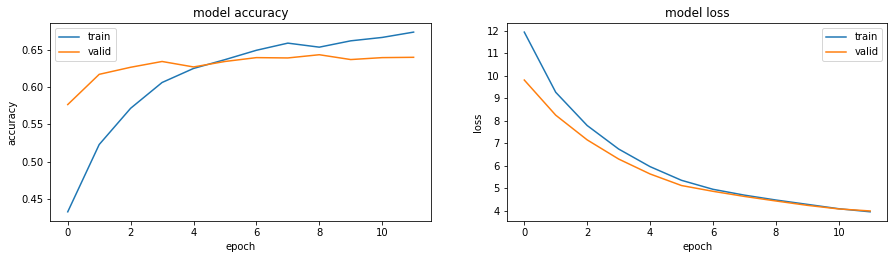

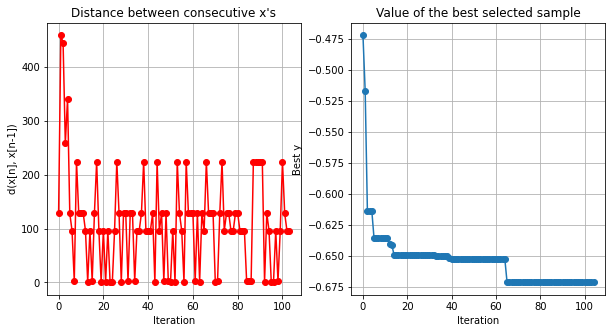

In [23]:
# define the kernel for the Bayesian surrogate model using the "radial basis function" (RBF)
kernel = GPy.kern.RBF(input_dim=1, variance=1.0, lengthscale=1.0)
# hyperparameter bounds
bounds = [{'name': 'units', 'type': 'discrete', 'domain': (64, 128, 256, 512)},
          {'name': 'learning_rate', 'type': 'discrete', 'domain': (1e-3, 1e-4, 1e-5, 1e-6)},
          {'name': 'l2', 'type': 'discrete', 'domain': (1e-1, 1e-2, 1e-3)},
          {'name': 'activation', 'type': 'discrete', 'domain': (1, 2, 3)},
          {'name': 'rate', 'type': 'discrete', 'domain': (0.3, 0.5, 0.7)},
          {'name': 'batch', 'type': 'discrete', 'domain': (32, 128, 256)},
          {'name': 'optim', 'type': 'discrete', 'domain': (1, 2, 3)}]
# Note: 'activation' domain parameters (1, 2, 3) correspond to strings ('relu', 'elu', 'tanh'); dictionary defined in build_model()
# Note: 'optim' domain parameters (1, 2, 3) correspond to strings ('Adam', 'SGD', 'RMSprop'); dictionary defined in build_model()
# objective function for the model optimization:
def f(x):
  """objective function of the Bayesian surrogate model"""
  print()
  print("Hyperparameters:", x)
  # Retrieve 'accuracy' from the previously saved model
  try:
    previous_best_model = K.models.load_model('DR_best.h5')
    previous_evaluation = evaluate_model(previous_best_model)
  except Exception:
    previous_best_model = None
  model, lr_reduce, early_stop, checkpoint, batch = build_model(
                                        units=int(x[:,0]),
                                        learning_rate=float(x[:,1]),
                                        l2=float(x[:,2]),
                                        activation=int(x[:,3]),
                                        rate=float(x[:,4]),
                                        batch=int(x[:,5]),
                                        optim=int(x[:,6]))
  history = fit_model(model, lr_reduce, early_stop, checkpoint, batch)
  evaluation = evaluate_model(model)
  print()
  print("LOSS:\t{0} \t ACCURACY:\t{1}".format(evaluation[0],evaluation[1]))
  #print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(evaluation[0], evaluation[1], evaluation[2], evaluation[3], evaluation[4]))
  print(evaluation)
  print()
  # compare previous and current validation accuracies
  if not previous_best_model:
    K.models.save_model(model, 'DR_best.h5', overwrite=True,
    include_optimizer=True)
  if previous_best_model and evaluation[1] > previous_evaluation[1]:
    K.models.save_model(model, 'DR_best.h5', overwrite=True,
    include_optimizer=True)
  # Get the dictionary containing each metric and the loss for each epoch
  # history_dict = history.history
  # print(history_dict)
  def plot_history(history):
  #function that plots the model loss and accuracy
    plt.figure(1, figsize = (15,8))
    plt.subplot(221)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'])
    plt.show()
  # plot the model accuracy and loss results
  plot_history(history)
  # delete the instantiated models from memory and clear the session
  del model
  del previous_best_model
  K.backend.clear_session()
  return evaluation[1]
# Initializing X and Y, and adding noise (if need be)
# X_init = np.array([[int(16)]])
# Y_init = f(X_init)
# noise = 0.2
optimizer = BayesianOptimization(f=f,
                                 domain=bounds,
                                 model_type='GP',
                                 kernel=kernel,
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.01,
                                 # X=X_init,
                                 # Y=-Y_init,
                                 # noise_var = noise**2,
                                 exact_feval=False,
                                 normalize_Y=False,
                                 maximize=True,
                                 verbosity=False)
print()
print("=====================")
print("=====================")
print()
optimizer.run_optimization(max_iter=100, verbosity=False)
optimizer.plot_acquisition()
optimizer.plot_convergence()
optimizer.save_report('bayes_opt.txt')

In [24]:
# print optimized model
activation_dict = {1: 'relu', 2: 'elu', 3: 'tanh'}
optimizer_dict = {1: 'Adam', 2: 'SGD', 3: 'RMSprop'}
print("""
Optimized Parameters:
\t{0}:\t{1}
\t{2}:\t{3}
\t{4}:\t{5}
\t{6}:\t{7}
\t{8}:\t{9}
\t{10}:\t{11}
""".format(bounds[0]["name"], optimizer.x_opt[0],
           bounds[1]["name"], optimizer.x_opt[1],
           bounds[2]["name"], optimizer.x_opt[2],
           bounds[3]["name"], activation_dict[optimizer.x_opt[3]],
           bounds[4]["name"], optimizer.x_opt[4],
           bounds[5]["name"], optimizer.x_opt[5]),
           bounds[6]["name"], optimizer_dict[optimizer.x_opt[6]])
print("optimized accuracy: {0}".format(abs(optimizer.fx_opt)))


Optimized Parameters:
	units:	512.0
	learning_rate:	0.001
	l2:	0.001
	activation:	elu
	rate:	0.3
	batch:	128.0
 optim Adam
optimized accuracy: [0.6712743]


In [8]:
# reinstantiate the best model from saved file
best_model = K.models.load_model('DR_best.h5')
best_model.summary()
loss, acc = best_model.evaluate(features_valid, y_test) 
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1920)]            0         
                                                                 
 dense (Dense)               (None, 512)               983552    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 986,117
Trainable params: 986,117
Non-trainable params: 0
_________________________________________________________________
73/73 [==============================] - 0s 3ms/step - loss: 1.1757 - accuracy: 0.6713
Restored model, accuracy: 67.13%


In [13]:
best_model.evaluate(features_valid, y_test)

73/73 [==============================] - 0s 2ms/step - loss: 1.1757 - accuracy: 0.6713


[1.1757407188415527, 0.6712743043899536]

In [ ]:
#print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(loss, acc, precision, recall, f1_score))

In [14]:
data_path = 'bayes_opt.txt'
with open(data_path, 'r') as f:
  lines = f.read().split('\n')
for line in lines:
  print(line)

----------------------------- GPyOpt Report file -----------------------------------
GPyOpt Version 1.2.1
Date and time:               Mon May 30 18:51:28 2022
Optimization completed:      NO,105 samples collected.
Number initial samples:      5 
Tolerance:                   1e-08.
Optimization time:           1375.0189809799194 seconds.

-------------------------------- Problem set up ------------------------------------
Problem name:                no_name
Problem dimension:           7
Number continuous variables  0
Number discrete variables    7
Number bandits               0
Noiseless evaluations:       False
Cost used:                   Used defined cost
Constrains:                  False

------------------------------ Optimization set up ---------------------------------
Normalized outputs:          False
Model type:                  GP
Model update interval:       1
Acquisition type:            EI
Acquisition optimizer:       lbfgs
Acquisition type:            EI
Acquisition o

Test model with test data

In [9]:
#https://stackoverflow.com/questions/55674648/how-to-load-local-dataset-x-y-using-keras-framework
from image_dataset_loader import load

(x_train, y_train), (x_test, y_test) = load('/content/output/', ['train', 'test'])

In [10]:
#  preprocess the data using the application's preprocess_input method and convert the labels to one-hot encodings
x_test, y_test = preprocess_data(x_test, y_test)

In [11]:

# repeat the same operation with the test data (here used for test)
test_datagen = K.preprocessing.image.ImageDataGenerator()  # no augmentation for validation set
test_generator = test_datagen.flow(x_test,
                                 y_test,
                                 batch_size=32,
                                 shuffle=False)
features_test = base_model.predict(test_generator)

In [12]:
# reinstantiate the best model from saved file
loss, acc = best_model.evaluate(features_test, y_test)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

37/37 [==============================] - 0s 3ms/step - loss: 1.1211 - accuracy: 0.6793
Restored model, accuracy: 67.93%


In [13]:
best_model.evaluate(features_test, y_test)

37/37 [==============================] - 0s 2ms/step - loss: 1.1211 - accuracy: 0.6793


[1.1211005449295044, 0.6792777180671692]

In [ ]:
#print("LOSS:\t{0} \t ACCURACY:\t{1} \t PRECISION:\t{2} \t RECALL:\t{3} \t F1-SCORE:\t{4}".format(loss, acc, precision, recall, f1_score))